# Figures for the Paper

Let's make some figures for the methods section of the paper.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

import numpy as np
import scipy.io
import pickle
import corner
import pandas as pd

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params
from stingray.modeling.gpmodeling import GPResult

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors

datadir = "/Users/daniela/work/data/grb230307A/"
figdir = "/Users/daniela/work/repositories/GRB230307A_QPOSearch/figures/"

INFO[2023-11-20 15:40:41,352]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1700491241.351976       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-11-20 15:40:41,353]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-11-20 15:40:41,368]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

## Useful Functions

Here are some useful functions I'm going to need:

In [2]:
def get_max_posterior_parameters(res):
    """
    Returns the optimal parameters for the model based on the NUTS sampling
    """
    max_post_idx = jnp.argmax(res.log_posterior_density)
    map_points = jax.tree_map(lambda x: x[max_post_idx], res.samples)

    return map_points

def plot_posterior_predictive(lc, res, kernel_type, mean_type, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    print("Resampling done, calculating maximum posterior model ...")
    # split into samples belonging to the kernel, and samples 
    # belonging to the mean function
    kernel_params = stingray.modeling.gpmodeling._get_kernel_params(kernel_type)
    mean_params = stingray.modeling.gpmodeling._get_mean_params(mean_type)

    mean_samples = dict((k, samples_resampled[k]) for k in mean_params)

    maxpost_log = get_max_posterior_parameters(res)

    sk_maxpost_log = dict((k, maxpost_log[k]) for k in kernel_params)
    sm_maxpost_log = dict((k, maxpost_log[k]) for k in mean_params)

    sk_maxpost, sm_maxpost = {}, {}
    for params in kernel_params:
        if params[0:4] == "log_":
            sk_maxpost[params[4:]] = jnp.exp(sk_maxpost_log[params])
        else:
            sk_maxpost[params] = sk_maxpost_log[params]

    for params in mean_params:
        if params[0:4] == "log_":
            sm_maxpost[params[4:]] = jnp.exp(sm_maxpost_log[params])
        else:
            sm_maxpost[params] = sm_maxpost_log[params]
            
    print(mean_type)
    kernel = get_kernel(kernel_type=kernel_type, kernel_params=sk_maxpost)
    mean = get_mean(mean_type=mean_type, mean_params=sm_maxpost)
    
    gp = GaussianProcess(kernel, lc.time, mean_value=mean(lc.time))
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)
    _, cond = gp.condition(lc.counts, tgrid)

    mu = cond.loc + mean(tgrid)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="GP Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = dict((k, mean_samples[k][idx]) for k in mean_params)
        sm = {}
        for params in mean_params:
            if params[0:4] == "log_":
                sm[params[4:]] = jnp.exp(sm_log[params])
            else:
                sm[params] = sm_log[params]

        mean = get_mean(mean_type=mean_type, mean_params=sm)
        mean_vals = mean(tgrid)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function \n posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

def resample_posterior(res, rkey):
    """
    Resample Nested Sampling posterior sample 
    based on the weights to provide unbiased
    posterior samples.

    Parameters
    ----------
    res : jaxns.Results object
        The object with the posterior results of 
        the Nested Sampling run

    rkey : jax.RandomState key
        A random key for reproducibility

    Returns
    -------
    samples_resampled : dict
        A dictionary with the resampled samples
    """
    log_p = res.log_dp_mean #log-prob

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    return samples_resampled

## INTEGRAL

Some figures about the INTEGRAL data.

First, let's read in the data:

In [3]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)
mean_bkg = np.mean(counts[-100:])

lc = Lightcurve(barytime, counts-mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-11-20 15:40:48,874]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-20 15:40:48,956]: Checking if light curve is sorted.
INFO[2023-11-20 15:40:49,038]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


### Posterior (Predictive) Plots for the INTEGRAL observation

In [4]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

times = lc.time
counts = lc.counts

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [5]:
with open(datadir+"intregal_drw_res.pkl", "rb") as f:
    res_rn = pickle.load(f)

In [6]:
samples_rn = resample_posterior(res_rn, rkey=random.PRNGKey(1342))

In [7]:
df_rn = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_rn["log_A"],
                      r"$t_0$": samples_rn["t0"],
                      r"$\log(\tau_\mathrm{rise})$":samples_rn["log_sig1"],
                      r"$\log(\tau_\mathrm{fall})$": samples_rn["log_sig2"],
                      r"$\log(A_{\mathrm{rn}})$": samples_rn["log_arn"],
                      r"$\log(c_\mathrm{rn})$": samples_rn["log_crn"]}
)

In [ ]:
sns.pairplot(df_rn, corner=True, diag_kind="hist", kind="kde", height=1.5)
plt.savefig(f"{figdir}integral_drw_corner.pdf", format="pdf")

<IPython.core.display.Javascript object>


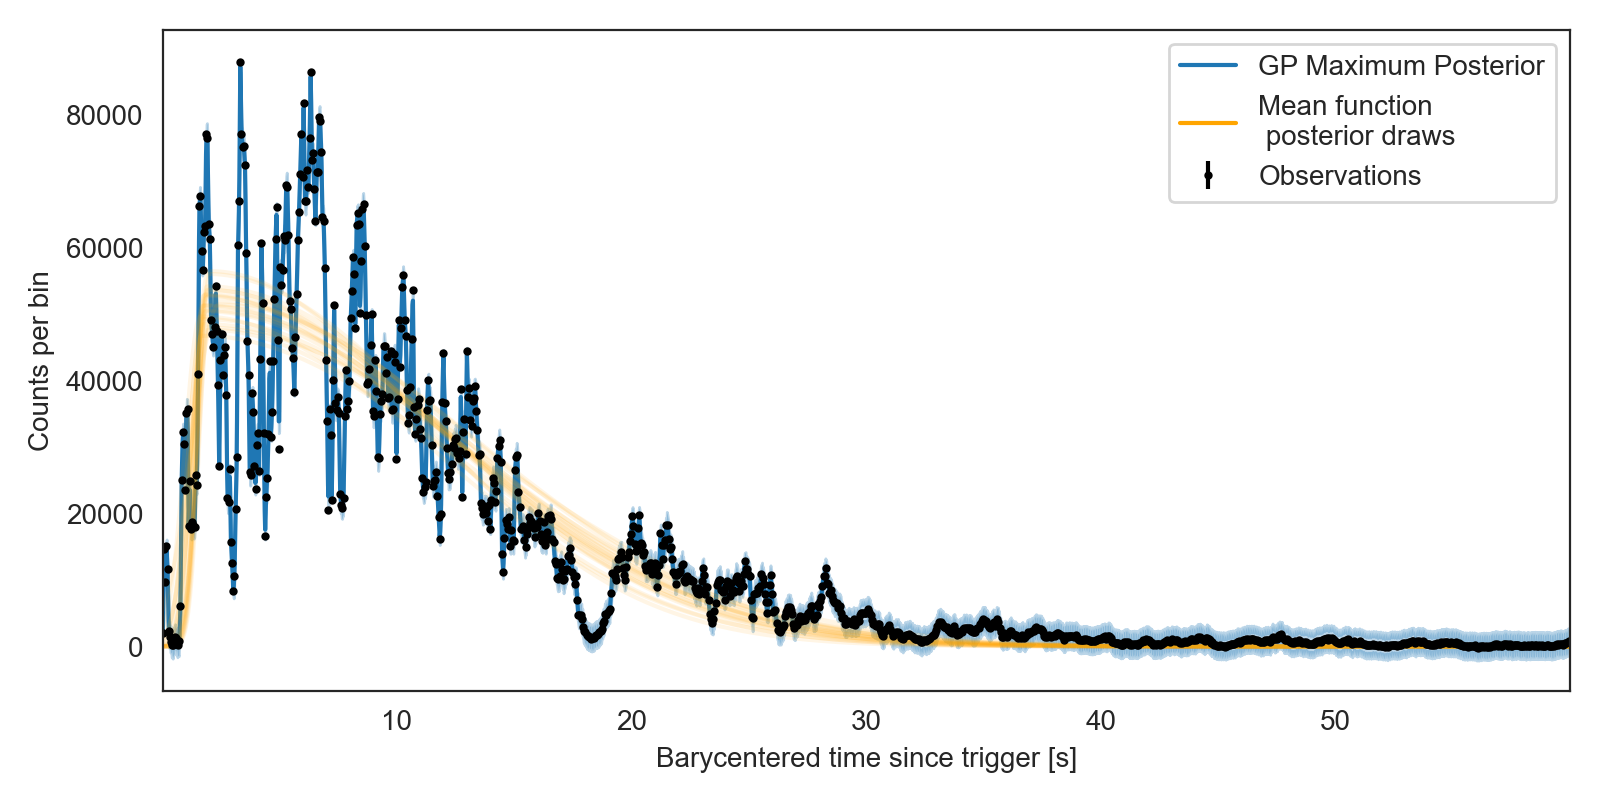

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, res_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

fig.tight_layout()

fig.savefig(f"{figdir}integral_drw_postpred.pdf", format="pdf")

Let's do the same for the QPO data:

In [33]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

with open(datadir+"intregal_drw_qpo_res.pkl", "rb") as f:
    res_qpo = pickle.load(f)

In [34]:
samples_qpo = resample_posterior(res_qpo, rkey=random.PRNGKey(135))

In [35]:
mask = samples_qpo["log_freq"] > -0.5

In [42]:
keys = ["log_A", "t0", "log_sig1", "log_sig2", 
        "log_arn", "log_crn", "log_freq", "log_aqpo","log_cqpo"]


In [36]:
df_qpo = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_qpo["log_A"][mask],
                      r"$t_0$": samples_qpo["t0"][mask],
                      r"$\log(\tau_\mathrm{rise})$":samples_qpo["log_sig1"][mask],
                      r"$\log(\tau_\mathrm{fall})$": samples_qpo["log_sig2"][mask],
                      r"$\log(A_{\mathrm{rn}})$": samples_qpo["log_arn"][mask],
                      r"$\log(c_\mathrm{rn})$": samples_qpo["log_crn"][mask],
                      r"$\log(\nu_c)$":samples_qpo["log_freq"][mask],
                      r"$\log(A_\mathrm{QPO})$":samples_qpo["log_aqpo"][mask],
                      r"$\log(c_\mathrm{QPO})$": samples_qpo["log_cqpo"][mask]}
)

In [43]:
var_names = np.array(df_qpo.columns)
sample_array = np.array([samples_qpo[v][mask] for v in keys])

In [41]:
import corner

<IPython.core.display.Javascript object>


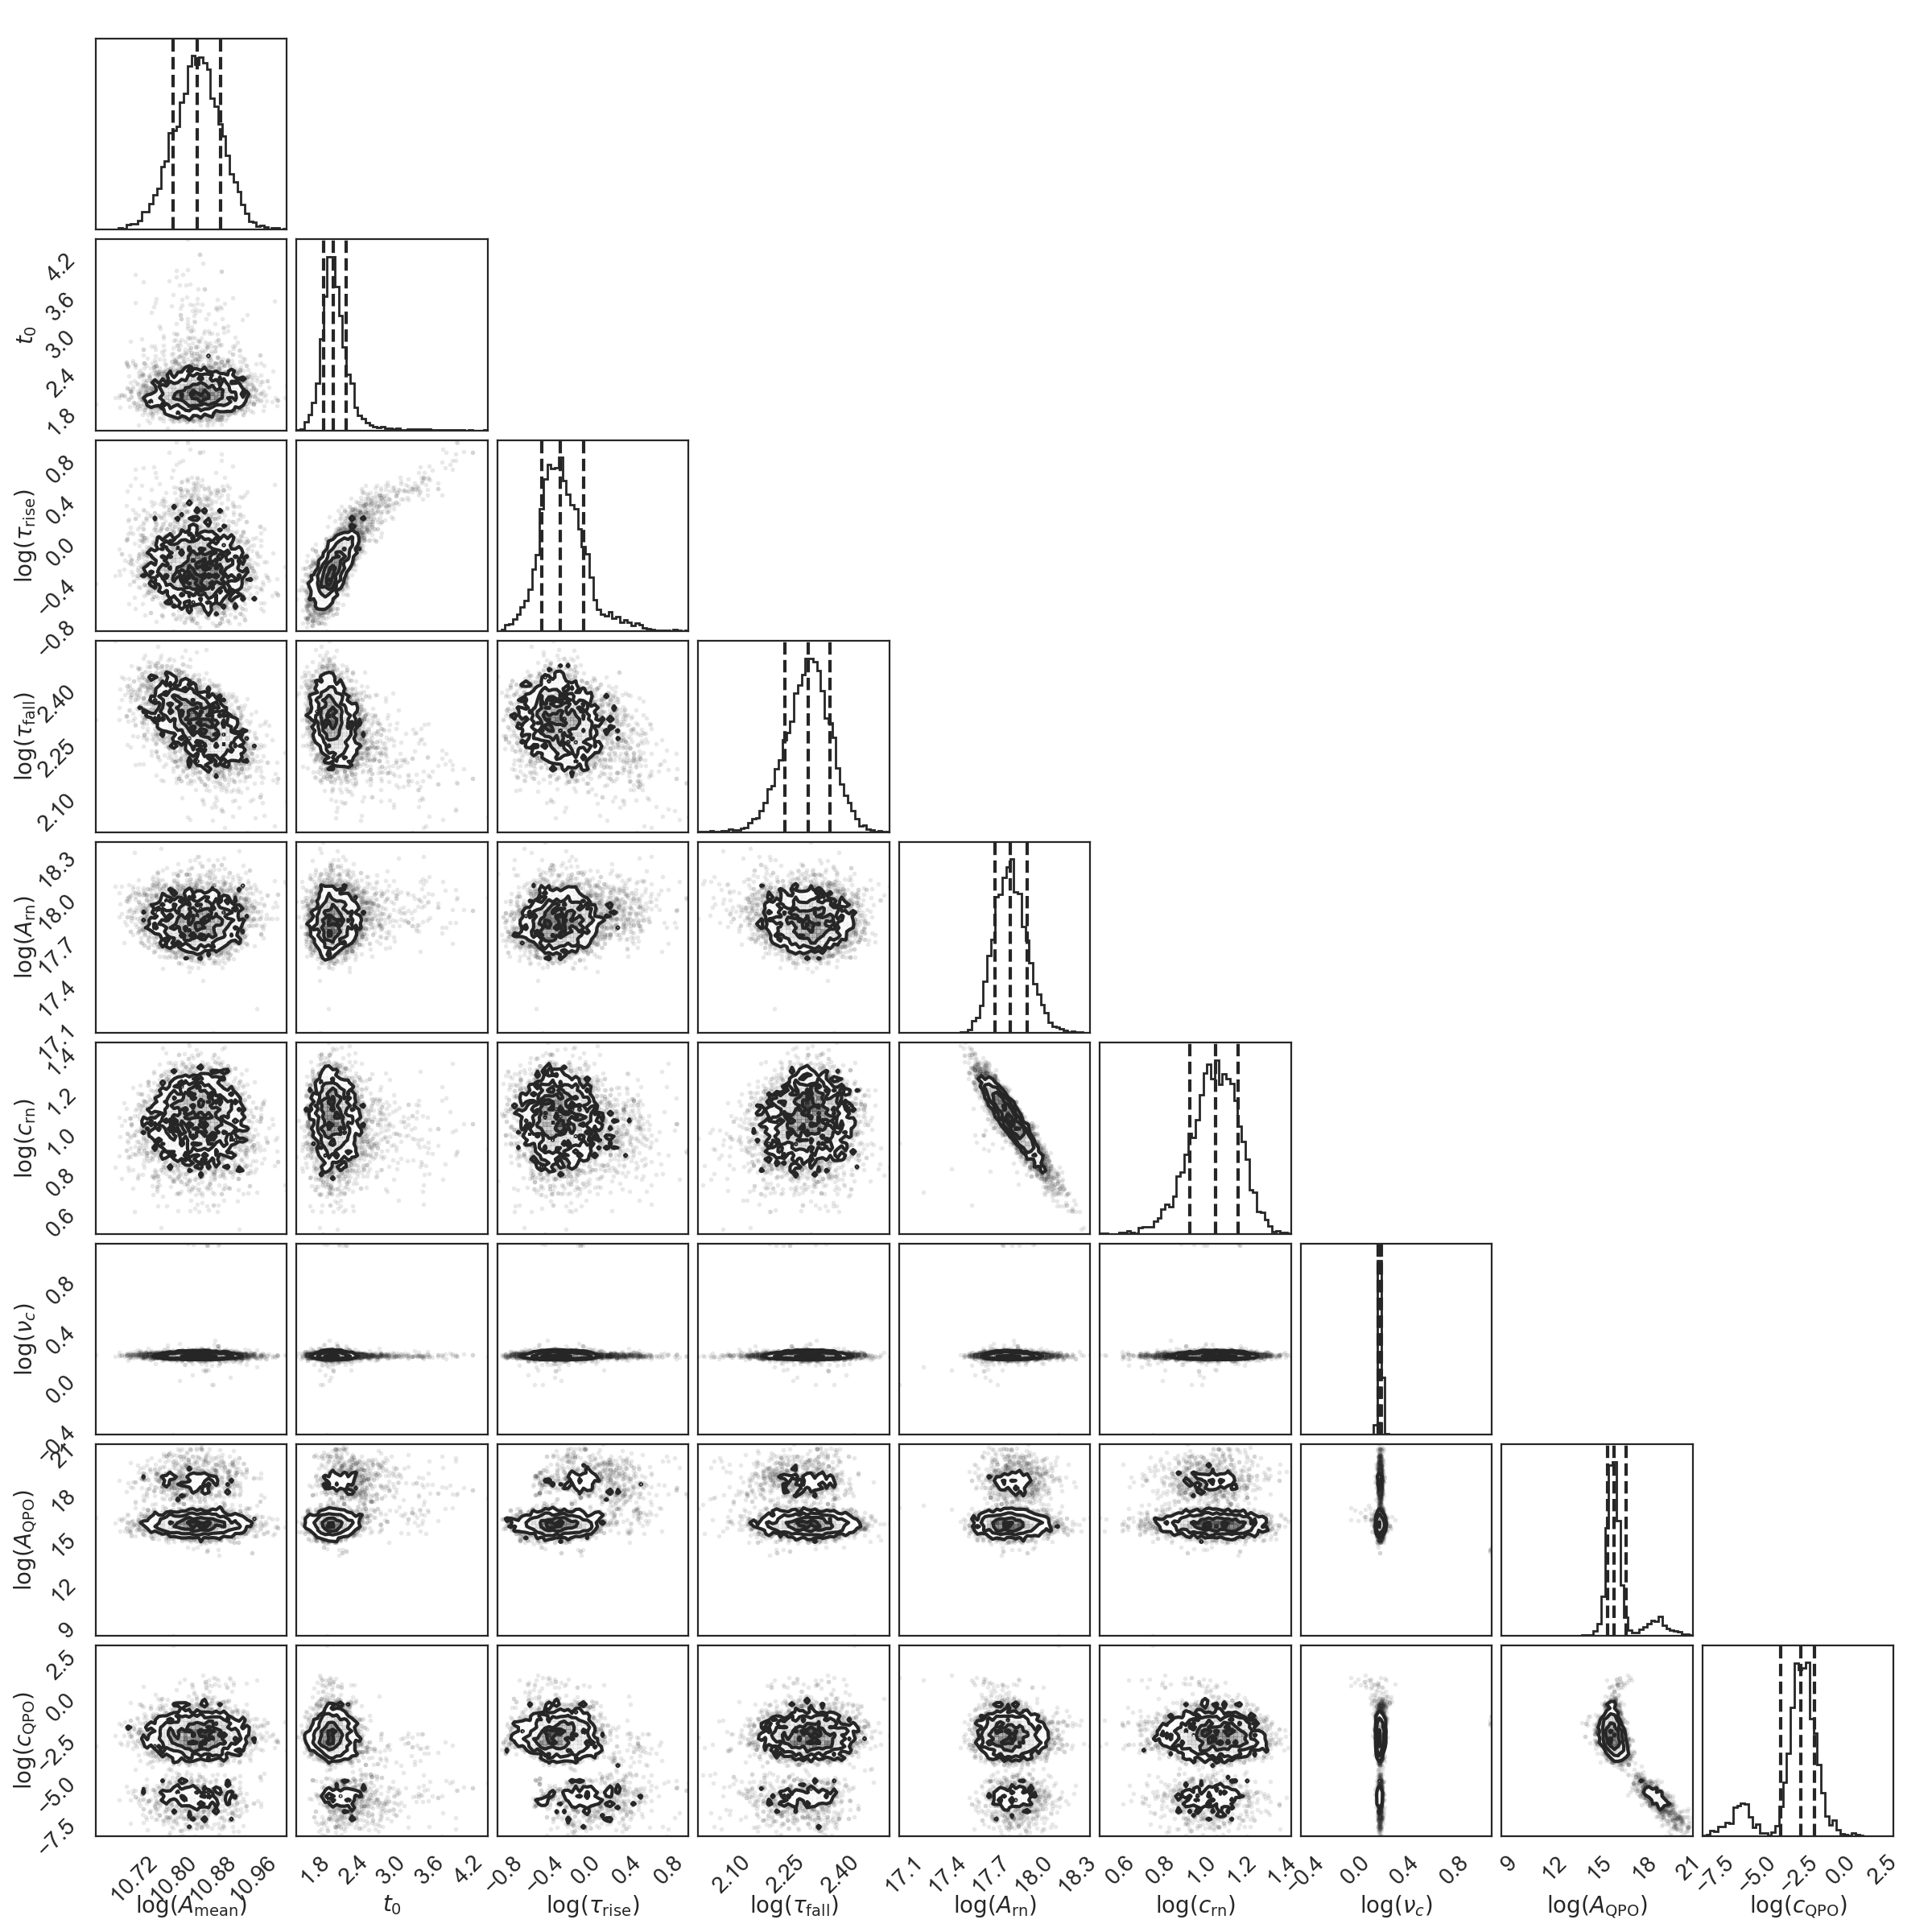

In [47]:
fig = plt.figure(figsize=(12,12))
fig = corner.corner(sample_array.T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=False,
              labels=var_names, fig=fig);
plt.savefig(f"{figdir}integral_qpo_corner.pdf", format="pdf")

<IPython.core.display.Javascript object>


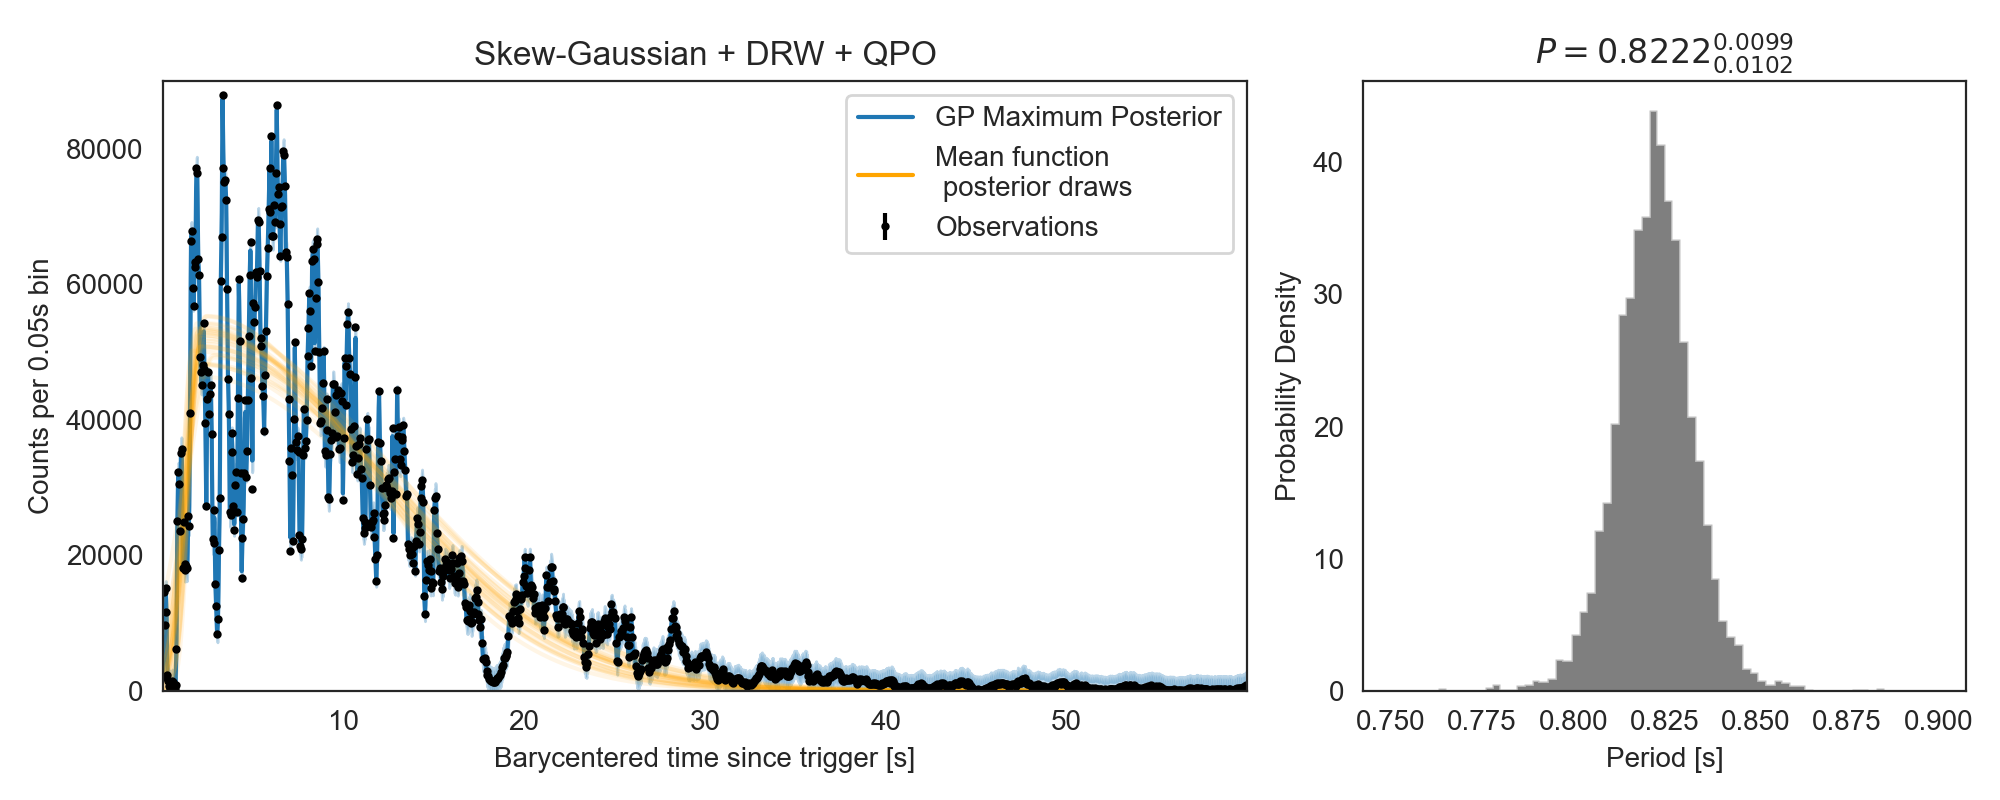

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


In [14]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10,4), width_ratios=[1.8, 1])


ax2 = plot_posterior_predictive(lc, res_qpo, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=ax2, rkey=None)

ax2.set_xlim(lc.time[0], lc.time[-1])
ax2.set_xlabel("Barycentered time since trigger [s]")
ax2.set_ylabel("Counts per 0.05s bin")
ax2.set_ylim(-10, 90000)
ax2.set_title("Skew-Gaussian + DRW + QPO")

period = 1./np.exp(samples_qpo["log_freq"])
histrange = (0.75, 0.9)

ax3.hist(period, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", range=histrange, density=True);
ax3.set_xlabel("Period [s]")
ax3.set_ylabel("Probability Density")

perc = np.percentile(period, [50-(68.5/2), 50, 50+(68.5/2)])
err = [perc[1] - perc[0], perc[2]-perc[1]]


ax3.set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc[1], err[1], err[0]))

fig.tight_layout()

fig.savefig(f"{figdir}integral_drw_qpo_postpred.pdf", format="pdf")

What's the quality factor?

[ 6.11749136 13.92044847 45.25701249]
31.336564024727306
7.80295710539557


<IPython.core.display.Javascript object>


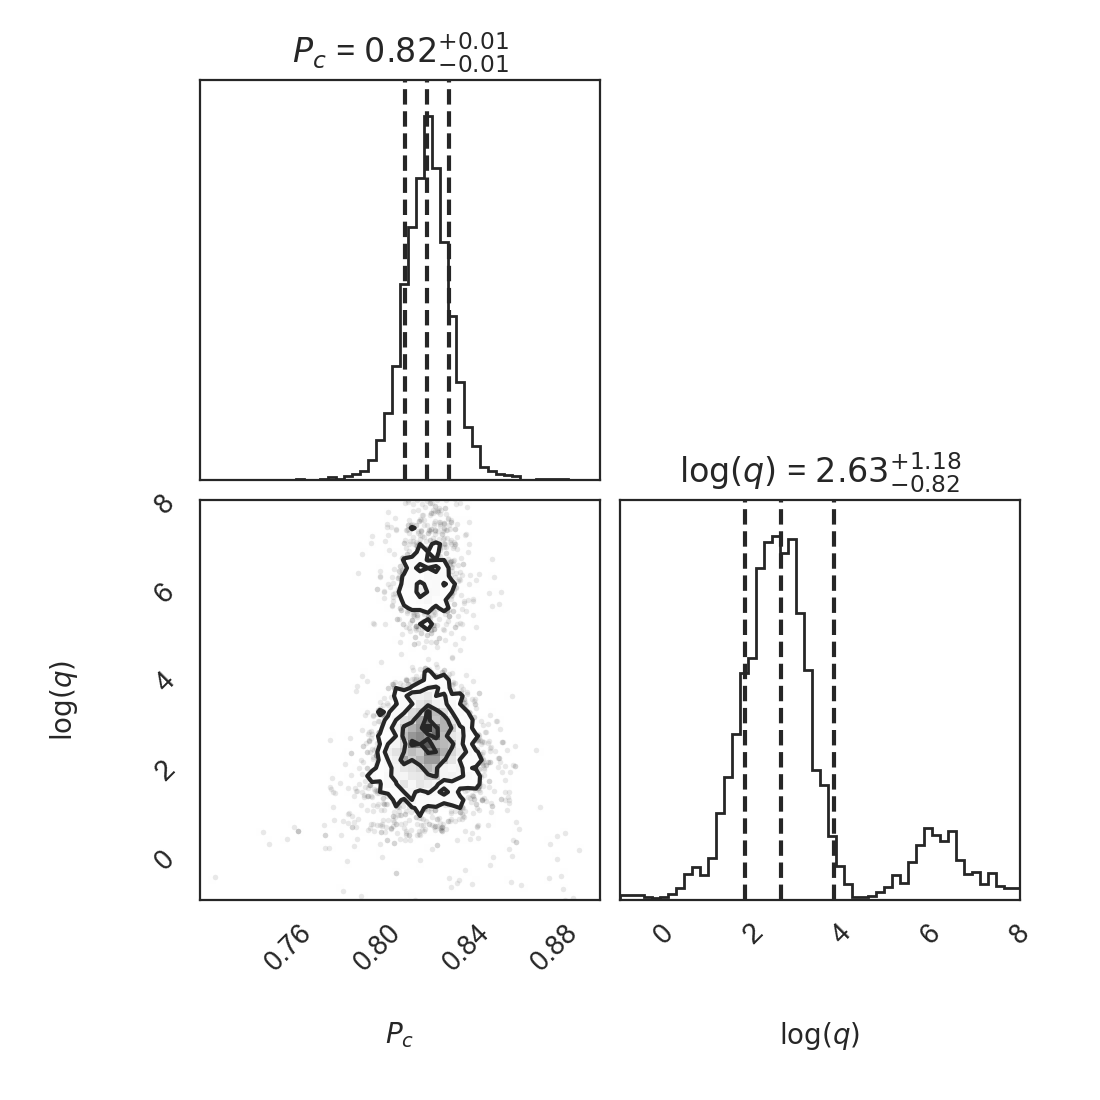

In [33]:
import corner
qual = np.exp(samples_qpo["log_freq"])/np.exp(samples_qpo["log_cqpo"])
perc = np.percentile(qual, [16, 50, 84])
print(perc)
print(perc[2]-perc[1])
print(perc[1]-perc[0])
corner.corner(np.array([period, np.log(qual)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.72, 0.9], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



Plot the residuals minus the mean function. Let's do this for the maximum posterior:

In [ ]:
maxpost_qpo_log = get_max_posterior_parameters(res_qpo)

maxpost_qpo= {}
for params in list(maxpost_qpo_log.keys()):
    if params[0:4] == "log_":
        maxpost_qpo[params[4:]] = jnp.exp(maxpost_qpo_log[params])
    else:
        maxpost_qpo[params] = maxpost_qpo_log[params]

mean_qpo = get_mean(mean_type, maxpost_qpo)
maxpost_mean = mean_qpo(lc.time)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, lc.counts-maxpost_mean, lw=1, color="black", ds="steps-mid")
ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Counts - Mean function")

plt.tight_layout()
plt.savefig(f"{figdir}integral_mean_residuals.pdf", format="pdf")
#ax.set_xlim(0, 20)
#ax.set_ylim(0, 100)
#ax.plot(lc.time, maxpost_mean)

## INTEGRAL: DRW False Alarm Proability 

False Alarm Probability for the DRW model:

In [ ]:
logz_qpo = np.loadtxt(f"{datadir}integral_sim_qpo_logz.txt")
logz_drw = np.loadtxt(f"{datadir}integral_sim_drw_logz.txt")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.log10(np.exp(logz_qpo[:,0] - logz_drw[:,0])), histtype="stepfilled", bins=15,
         alpha=0.5, color="black", label="simulations", density=True)
ax.axvline(np.log10(np.exp(res_qpo.log_Z_mean - res_rn.log_Z_mean)), 
            lw=2, color="red", label="observation")
ax.set_xlabel(r"$\log(\mathcal{B}_{21})$")
ax.set_ylabel("Probability Density")
ax.legend()

plt.savefig(f"{figdir}integral_drw_fap.pdf", format="pdf")

## Goodness of Fit for the INTEGRAL data

In [ ]:
r2_rn_all = np.loadtxt(f"{datadir}integral_drw_r2_rn.dat")
r2_qpo_all = np.loadtxt(f"{datadir}integral_drw_r2_qpo.dat")

In [ ]:
np.std(r2_rn_all)

In [ ]:
np.std(r2_qpo_all)

In [ ]:
np.mean(r2_rn_all)

In [ ]:
np.mean(r2_qpo_all)

In [ ]:
histrange = [np.min(np.hstack([r2_rn_all, r2_qpo_all])), np.max(np.hstack([r2_rn_all, r2_qpo_all]))]

nbins = 80

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.mean(r2_rn_all, axis=1), histtype="stepfilled", bins=nbins,
        alpha=0.5, range=histrange, label="DRW", density=True)
ax.hist(np.mean(r2_qpo_all, axis=1), histtype="stepfilled", bins=nbins,
        alpha=0.5, range=histrange, label="DRW + QPO", density=True)
ax.set_xlim(0.02, 0.04)

ax.legend()
ax.set_xlabel("Fraction of Variance Unexplained")
ax.set_ylabel("Probability Density")

fig.tight_layout()
fig.savefig(f"{figdir}integral_fuv.pdf", format="pdf")

## INTEGRAL Data: Cutouts

Let's look at the cutout version of the INTEGRAL data:

<IPython.core.display.Javascript object>


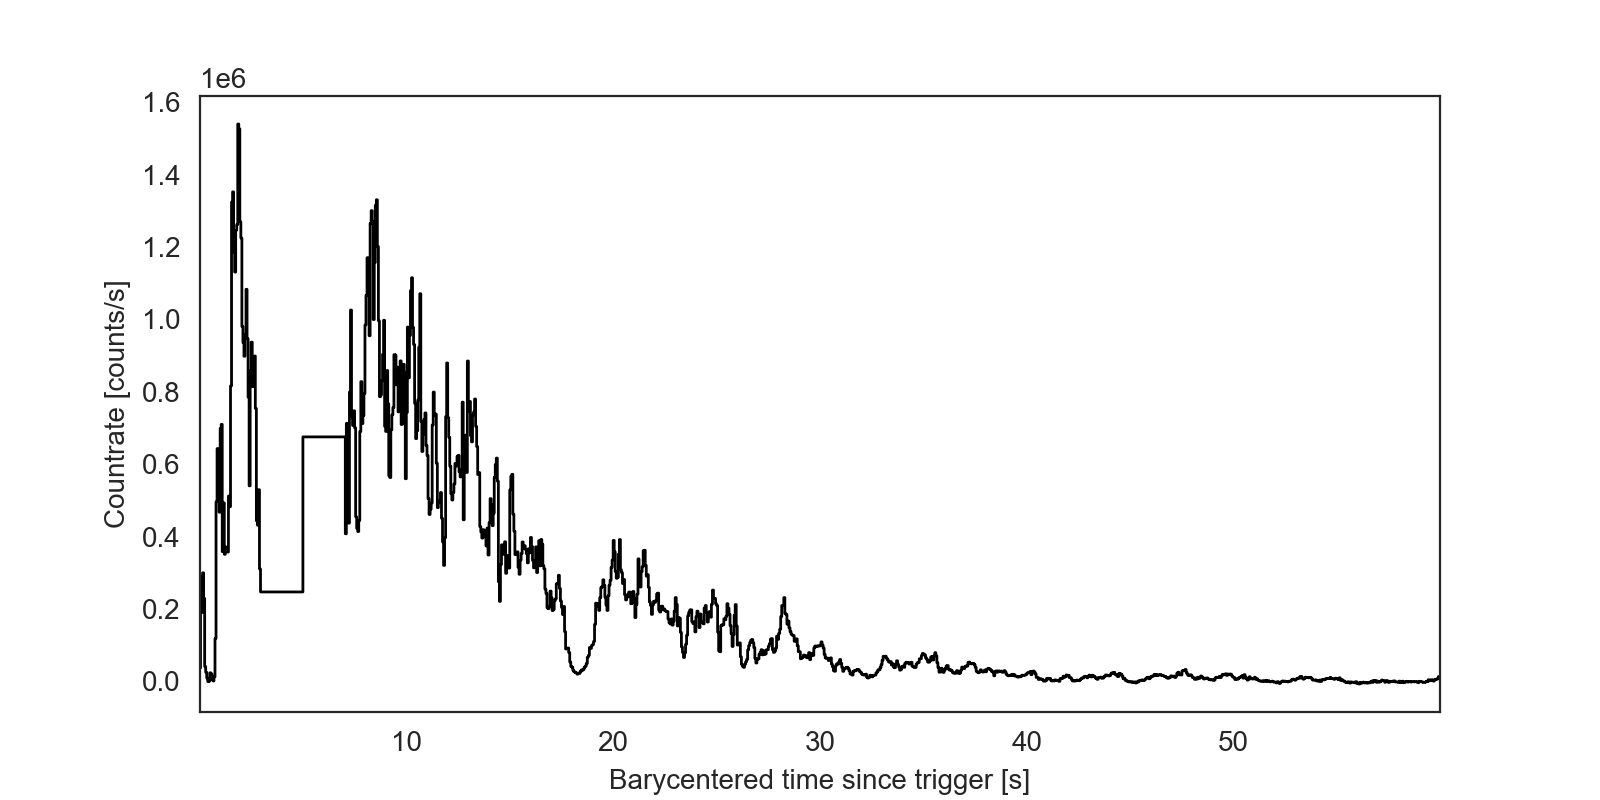

Text(0, 0.5, 'Countrate [counts/s]')

In [34]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

#lc = Lightcurve(barytime, counts-mean_bkg)
minind = barytime.searchsorted(0.0)
cutout_min = barytime.searchsorted(3.0)
cutout_max = barytime.searchsorted(7.0)
maxind = barytime.searchsorted(60.0)

t1 = barytime[minind:cutout_min]
t2 = barytime[cutout_max:maxind]
time = np.hstack([t1, t2])

c1 = counts[minind:cutout_min]
c2 = counts[cutout_max:maxind]
counts = np.hstack([c1, c2])

mean_bkg = np.mean(counts[-100:])

lc = Lightcurve(time, counts-mean_bkg, dt=time[1]-time[0], skip_checks=True)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Countrate [counts/s]")


### DRW Only Plots

In [35]:
with open(datadir+"intregal_drw_cutout_res.pkl", "rb") as f:
    res_rn_cutout = pickle.load(f)

In [36]:
samples_rn_cutout = resample_posterior(res_rn_cutout, rkey=random.PRNGKey(13553))

df_rn_cutout = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_rn_cutout["log_A"],
                      r"$t_0$": samples_rn_cutout["t0"],
                      r"$\log(\tau_\mathrm{rise})$":samples_rn_cutout["log_sig1"],
                      r"$\log(\tau_\mathrm{fall})$": samples_rn_cutout["log_sig2"],
                      r"$\log(A_{\mathrm{rn}})$": samples_rn_cutout["log_arn"],
                      r"$\log(c_\mathrm{rn})$": samples_rn_cutout["log_crn"]}
                      #r"$\log(\nu_c)$":samples_qpo["log_freq"],
                      #r"$\log(A_\mathrm{QPO})$":samples_qpo["log_aqpo"],
                      #r"$\log(c_\mathrm{QPO})$": samples_qpo["log_cqpo"]}
)

In [ ]:

sns.pairplot(df_rn_cutout, corner=True, height=1.5, kind="kde", diag_kind="hist")
plt.savefig(f"{figdir}integral_cutout_rn_corner.pdf", format="pdf")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, res_rn_cutout, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

fig.tight_layout()

fig.savefig(f"{figdir}integral_cutout_drw_postpred.pdf", format="pdf")

### INTEGRAL Cutout: DRW + QPO Model

In [37]:
with open(datadir+"intregal_drw_qpo_cutout_res.pkl", "rb") as f:
    res_qporn_cutout = pickle.load(f)

In [38]:
samples_qporn_cutout = resample_posterior(res_qporn_cutout, rkey=random.PRNGKey(13553))

df_qporn_cutout = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_qporn_cutout["log_A"],
                      r"$t_0$": samples_qporn_cutout["t0"],
                      r"$\log(\tau_\mathrm{rise})$":samples_qporn_cutout["log_sig1"],
                      r"$\log(\tau_\mathrm{fall})$": samples_qporn_cutout["log_sig2"],
                      r"$\log(A_{\mathrm{rn}})$": samples_qporn_cutout["log_arn"],
                      r"$\log(c_\mathrm{rn})$": samples_qporn_cutout["log_crn"],
                      r"$\log(\nu_c)$":samples_qporn_cutout["log_freq"],
                      r"$\log(A_\mathrm{QPO})$":samples_qporn_cutout["log_aqpo"],
                      r"$\log(c_\mathrm{QPO})$": samples_qporn_cutout["log_cqpo"]}
                              )

In [ ]:

sns.pairplot(df_qporn_cutout, corner=True, height=1.5, kind="kde", diag_kind="hist")
plt.savefig(f"{figdir}integral_cutout_qpo_rn_corner.pdf", format="pdf")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1 = plot_posterior_predictive(lc, res_rn_cutout, kernel_type, mean_type, 
                               nmean=25, ngrid=3000, ax=ax1, rkey=None)

ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Counts per bin")
ax1.set_title("Skew-Gaussian + DRW")

ax2 = plot_posterior_predictive(lc, res_qporn_cutout, kernel_type, mean_type, 
                               nmean=25, ngrid=3000, ax=ax2, rkey=None)

ax2.set_xlim(lc.time[0], lc.time[-1])
ax2.set_xlabel("Barycentered time since trigger [s]")
#ax2.set_ylabel("Counts per bin")
ax2.legend([])
ax2.get_yaxis().set_ticks([])
ax2.set_title("Skew-Gaussian + DRW + QPO")

period = 1./np.exp(samples_qporn_cutout["log_freq"])

histrange = [0.33, 0.355]
ax3.hist(period, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", range=histrange, density=True);
ax3.set_xlabel("Period [s]")
ax3.set_ylabel("Probability Density")

perc = np.percentile(period, [50-(68.5/2), 50, 50+(68.5/2)])
err = [perc[1] - perc[0], perc[2]-perc[1]]


ax3.set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc[1], err[1], err[0]))

fig.tight_layout()

fig.savefig(f"{figdir}integral_cutout_drw_qpo_postpred.pdf", format="pdf")

In [44]:
period = 1./np.exp(samples_qporn_cutout["log_freq"])

perc_freq = np.percentile(np.exp(samples_qporn_cutout["log_freq"]), [50-(68.5/2), 50, 50+(68.5/2)])
err_freq = [perc_freq[1] - perc_freq[0], perc_freq[2]-perc_freq[1]]

qual = np.exp(samples_qporn_cutout["log_freq"]) / np.exp(samples_qporn_cutout["log_cqpo"])
perc_qual = np.percentile(qual, [50-(68.5/2), 50, 50+(68.5/2)])
err_qual = [perc_qual[1] - perc_qual[0], perc_qual[2]-perc_qual[1]]

In [45]:
print(perc_freq[1])
print(err_freq[1])
print(err_freq[0])

2.8813142684339024
0.00809759054803294
0.0076257789986300395


In [46]:
print(perc_qual[1])
print(err_qual[1])
print(err_qual[0])

118.42354474229953
93.57332197632547
48.64406862456545


<IPython.core.display.Javascript object>


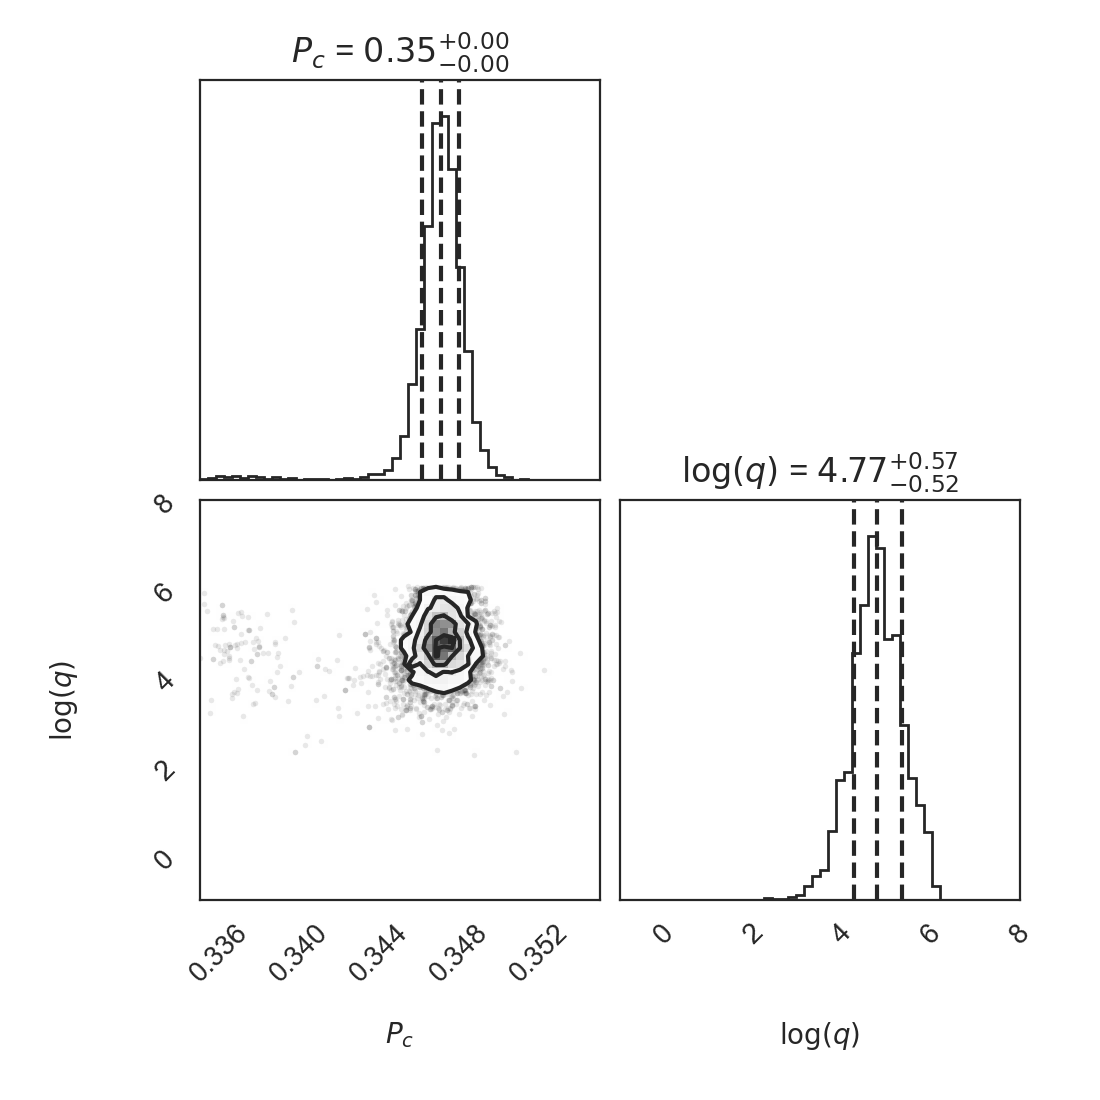

In [49]:
import corner
#qual = np.exp(samples_qpo["log_freq"])/np.exp(samples_qpo["log_cqpo"])
#perc = np.percentile(qual, [16, 50, 84])
#print(perc)
#print(perc[2]-perc[1])
#print(perc[1]-perc[0])

corner.corner(np.array([period, np.log(qual)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.335, 0.355], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



## INTEGRAL Data, DRW: Split Light Curve

In [83]:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)
mean_bkg = np.mean(counts[-100:])

lc = Lightcurve(barytime, counts-mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-10-27 15:27:45,174]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-27 15:27:45,186]: Checking if light curve is sorted.
INFO[2023-10-27 15:27:45,189]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


In [84]:
split_idx1 = lc.time.searchsorted(18.0)
split_idx2 = lc.time.searchsorted(19.0)

lc1 = lc.truncate(start=0, stop=split_idx1)
lc2 = lc.truncate(start=split_idx2, stop=len(lc.time))

In [85]:
with open(datadir+"intregal_drw_qpo_lc1_res.pkl", "rb") as f:
    res_qporn1 = pickle.load(f)
    
with open(datadir+"intregal_drw_qpo_lc2_res.pkl", "rb") as f:
    res_qporn2 = pickle.load(f)

In [86]:
samples_qporn1 = resample_posterior(res_qporn1, rkey=random.PRNGKey(13753))
samples_qporn2 = resample_posterior(res_qporn2, rkey=random.PRNGKey(13793))

freq1 = np.exp(samples_qporn1["log_freq"])
freq2 = np.exp(samples_qporn2["log_freq"])

period1 = 1./freq1
period2 = 1./freq2

<IPython.core.display.Javascript object>


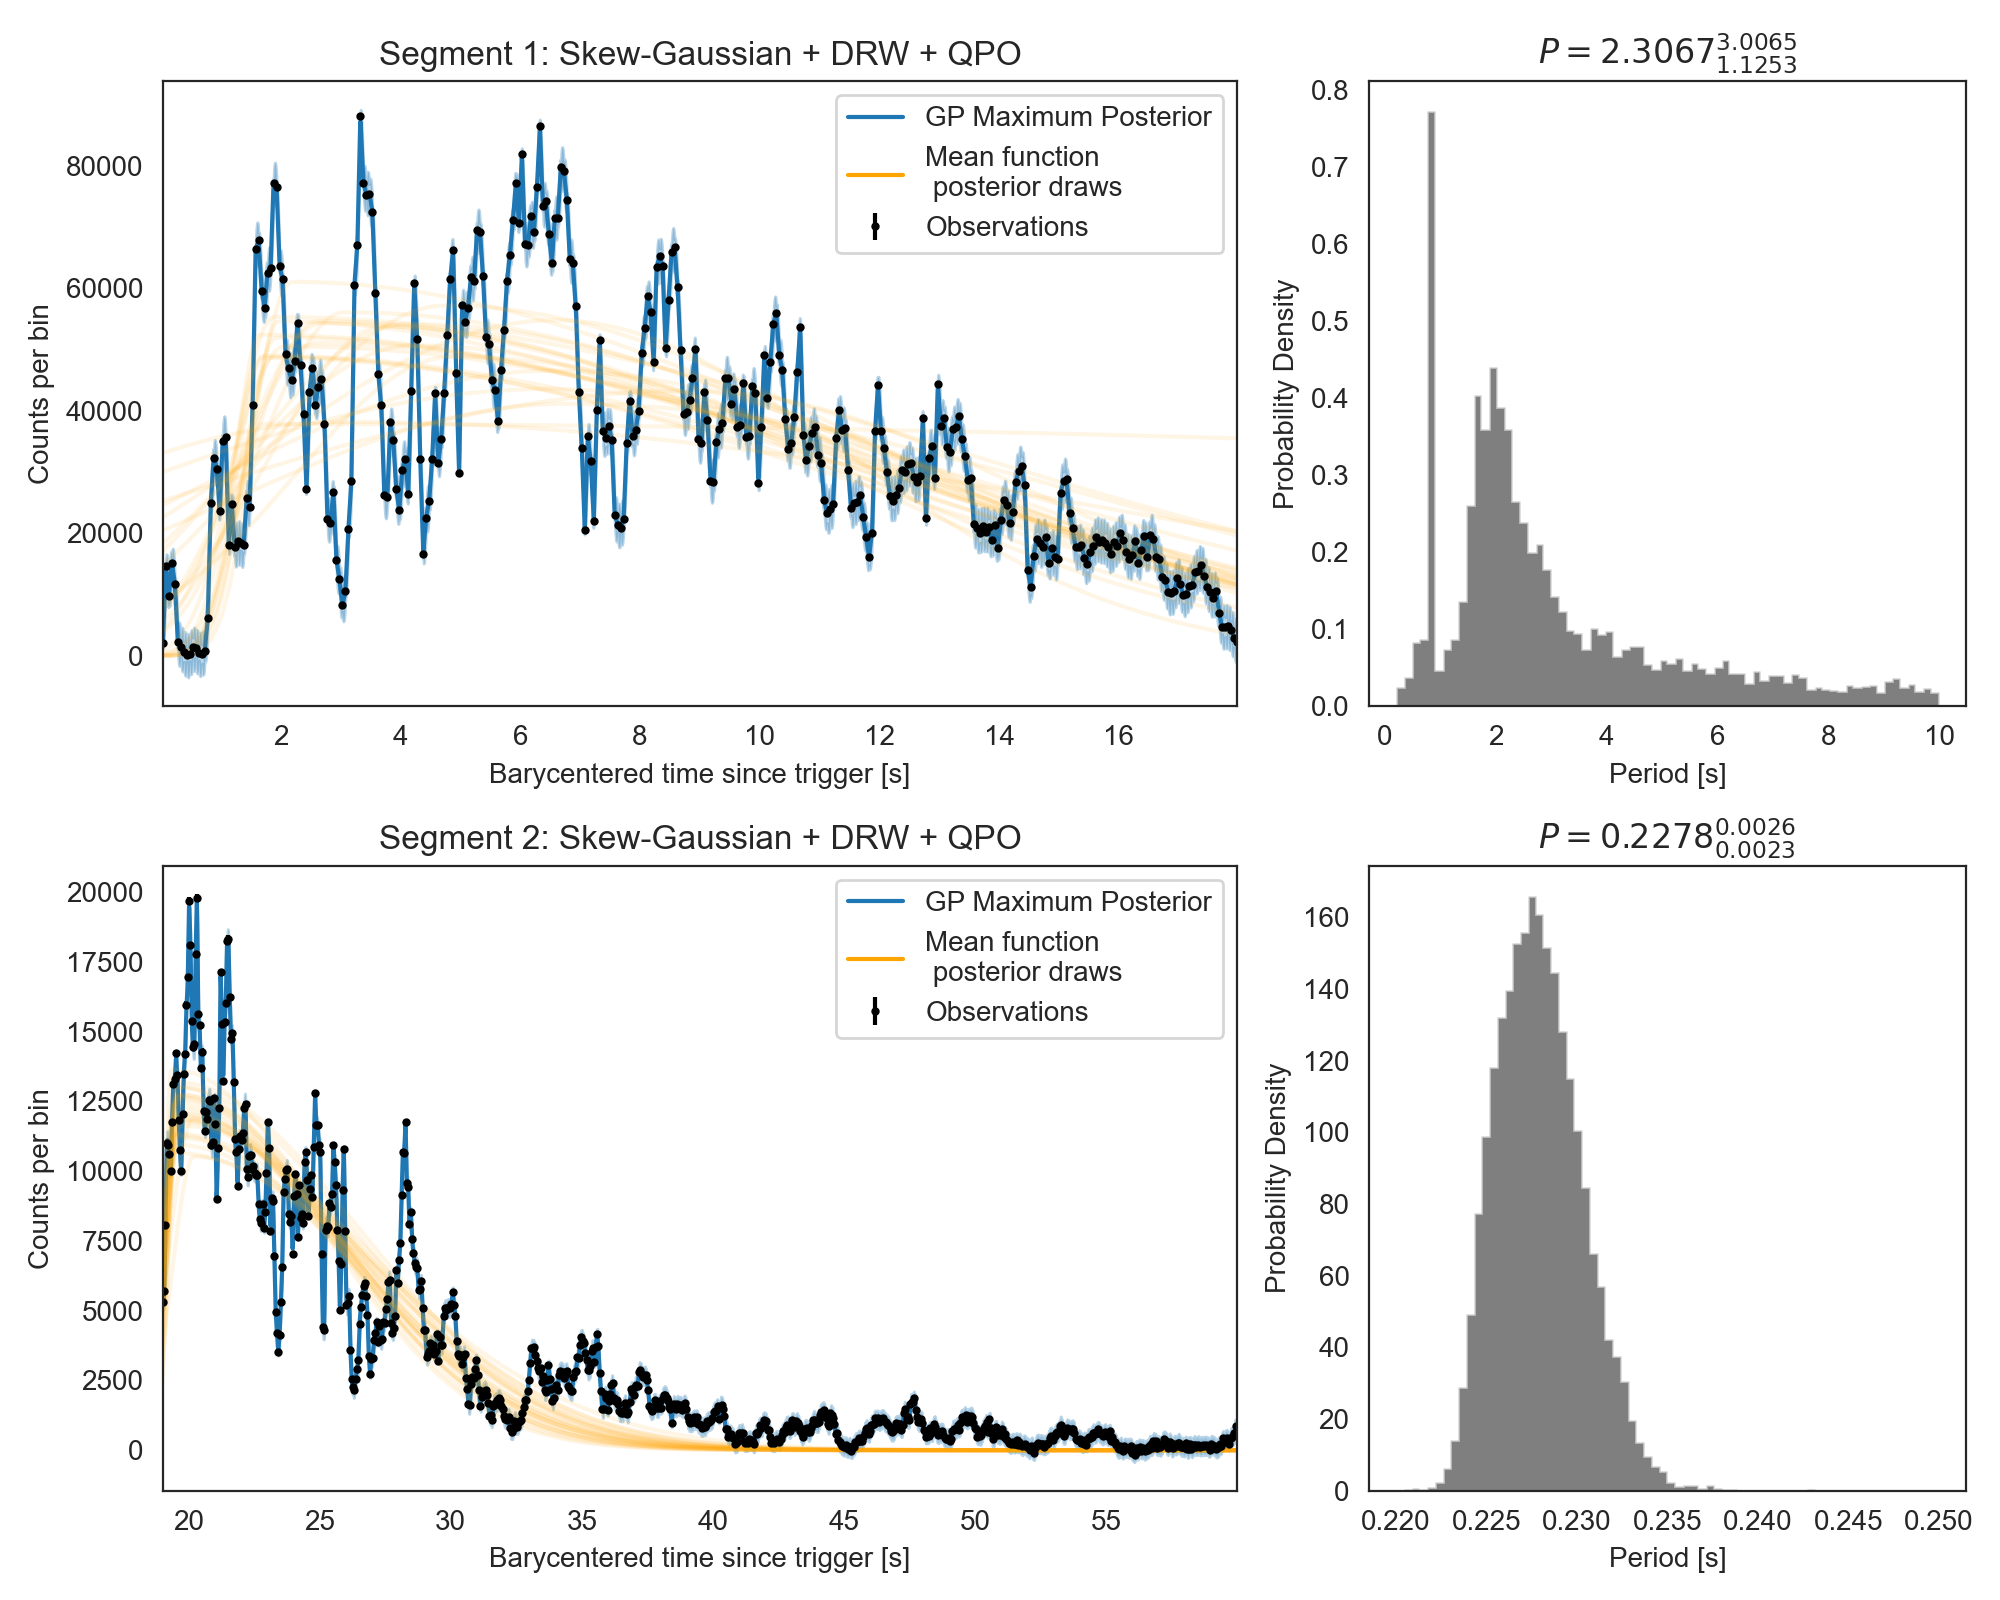

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...
Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


In [90]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), width_ratios=[1.8, 1.0])

axes = np.hstack(axes)

axes[0] = plot_posterior_predictive(lc1, res_qporn1, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[0], rkey=None)


axes[2] = plot_posterior_predictive(lc2, res_qporn2, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[2], rkey=None)

axes[0].set_xlim(lc1.time[0], lc1.time[-1])
axes[0].set_xlabel("Barycentered time since trigger [s]")
axes[0].set_ylabel("Counts per bin")
axes[0].set_title("Segment 1: Skew-Gaussian + DRW + QPO")

axes[2].set_xlim(lc2.time[0], lc2.time[-1])
axes[2].set_xlabel("Barycentered time since trigger [s]")
axes[2].set_ylabel("Counts per bin")
axes[2].set_title("Segment 2: Skew-Gaussian + DRW + QPO")


#histrange = [0.33, 0.355]
axes[1].hist(period1, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True);
axes[1].set_xlabel("Period [s]")
axes[1].set_ylabel("Probability Density")

perc1 = np.percentile(period1, [50-(68.5/2), 50, 50+(68.5/2)])
err1 = [perc1[1] - perc1[0], perc1[2]-perc1[1]]

axes[1].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc1[1], err1[1], err1[0]))

histrange2 = [0.22,0.25]
axes[3].hist(period2, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange2);
axes[3].set_xlabel("Period [s]")
axes[3].set_ylabel("Probability Density")

perc2 = np.percentile(period2, [50-(68.5/2), 50, 50+(68.5/2)])
err2 = [perc2[1] - perc2[0], perc2[2]-perc2[1]]

axes[3].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc2[1], err2[1], err2[0]))

fig.tight_layout()
fig.savefig(f"{figdir}integral_drw_qpo_split_postpred.pdf", format="pdf")

## INTEGRAL Data: CARMA Model

In [15]:
def carma21_integral_with_qpo(t, y=None):
    
    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(5, 11.5))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 20))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-1, 3.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 3.5))

    params = [log_amp, t0, log_sig1,log_sig2]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-20, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-20, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(2, 20))
        
    kernel_carma = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])

    # QPO kernel parameters
    log_aqpo = numpyro.sample("log_aqpo", dist.Uniform(1, 15))
    log_quality = numpyro.sample("log_quality", dist.Uniform(jnp.log(2.0), jnp.log(50.0)))
    log_omega = numpyro.sample("log_omega", dist.Uniform(np.log(2.*np.pi*0.1), np.log(2.*np.pi*5)))
    
    # QPO kernel
    kernel_qpo = kernels.quasisep.SHO(
            sigma=jnp.exp(log_aqpo),
            omega=jnp.exp(log_omega),
            quality = jnp.exp(log_quality)
        )
    
    # add kernels together
    kernel = kernel_carma + kernel_qpo

    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)
        
def plot_posterior_predictive_carma_qpo(lc, res, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    mean_var_names = ["log_amp", "t0", "log_sig1",
                    'log_sig2']

    mean_samples = dict((k, samples_resampled[k]) for k in mean_var_names)

    print("Resampling done, calculating maximum posterior model ...")

    maxpost_log = get_max_posterior_parameters(res)

    mean_params = [maxpost_log["log_amp"],
                   maxpost_log["t0"],
                   maxpost_log["log_sig1"],
                   maxpost_log["log_sig2"]]

    alpha = [jnp.exp(maxpost_log["log_alpha1"]), jnp.exp(maxpost_log["log_alpha2"])]
    beta = [jnp.exp(maxpost_log["log_beta"])]
    
    omega = jnp.exp(maxpost_log["log_omega"])
    quality = jnp.exp(maxpost_log["log_quality"])
    aqpo = jnp.exp(maxpost_log["log_aqpo"])

    mean_val = skewgaussian(lc.time, mean_params)
    kernel_carma = CARMA.init(alpha=alpha, beta=beta)
    kernel_qpo = kernels.quasisep.SHO(omega=omega, quality=quality, sigma=aqpo)
    
    kernel = kernel_carma + kernel_qpo

    gp = GaussianProcess(kernel, lc.time, diag=0.01, mean_value=mean_val)
    _, cond = gp.condition(lc.counts, tgrid, include_mean=True)


    mu = cond.loc + skewgaussian(tgrid, mean_params)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = [mean_samples[k][idx] for k in mean_var_names]

        mean_vals = skewgaussian(tgrid, sm_log)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]

    y = jnp.exp(logA) * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        )
    return y

In [11]:
with open(datadir + "integral_carma21_qpo_ns_slowrun.pkl", "rb") as f:
    ns_carma = pickle.load(f)

In [13]:
samples_carma, weights_carma = ns_carma.get_weighted_samples()
freq_post = np.exp(samples_carma["log_omega"])/(2.*np.pi)

In [17]:
from tinygp.kernels.quasisep import CARMA

<IPython.core.display.Javascript object>


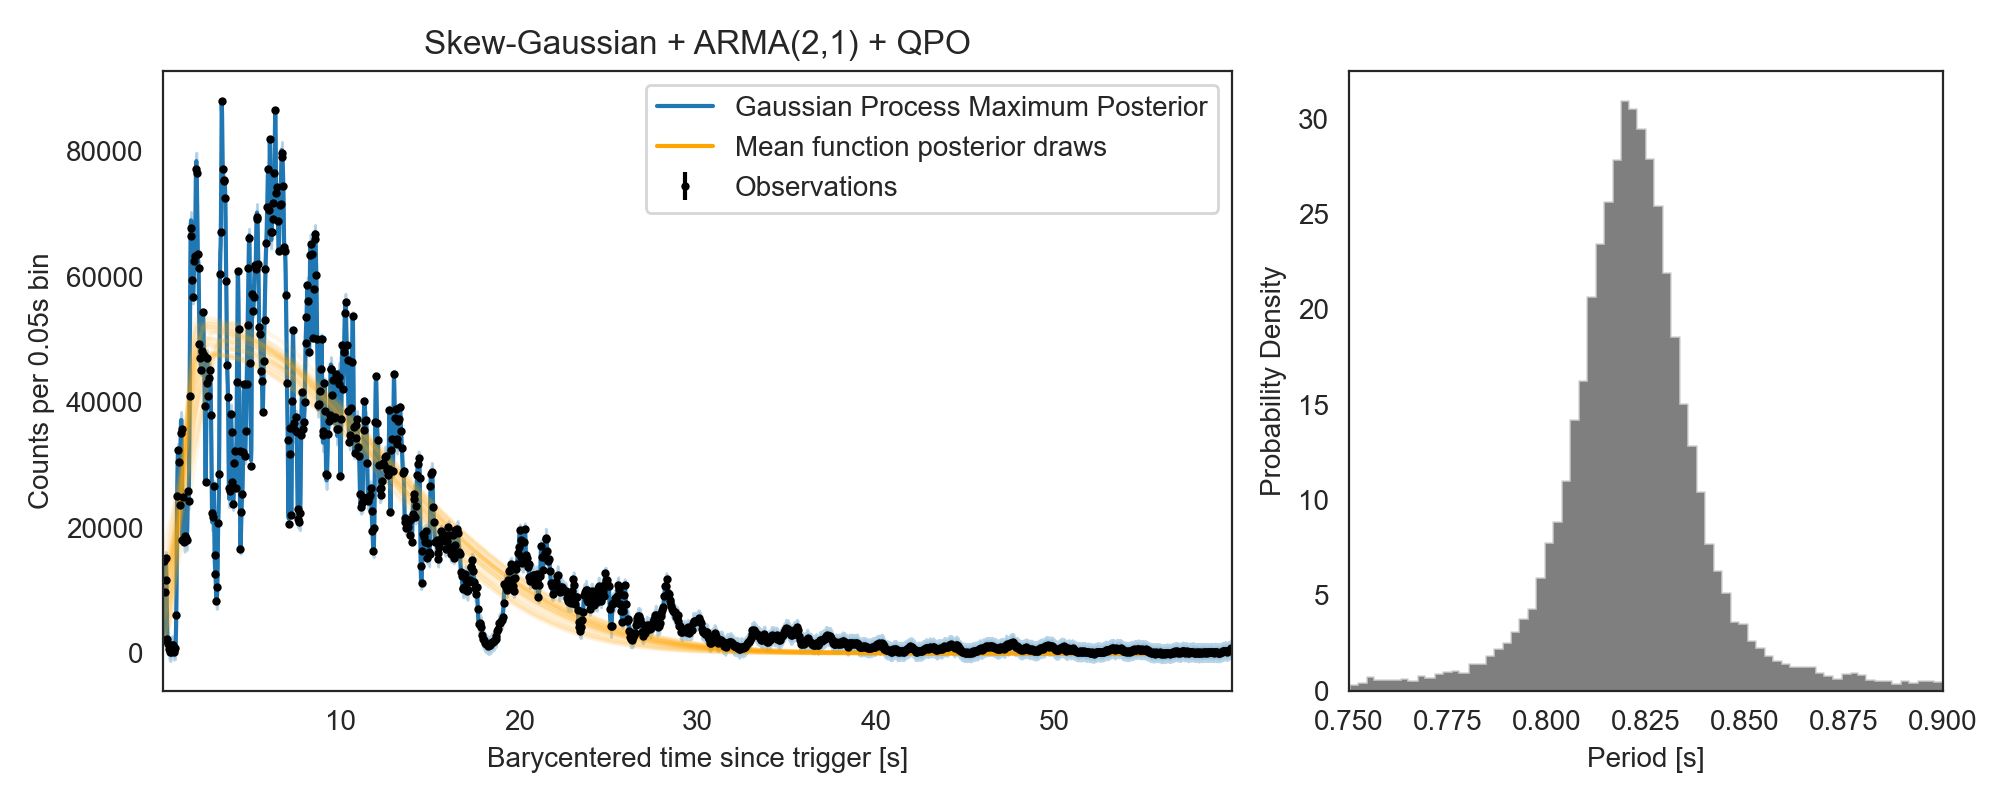

Resampling done, calculating maximum posterior model ...
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


In [32]:
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10,4), width_ratios=[1.8, 1])


ax2 = plot_posterior_predictive_carma_qpo(lc, ns_carma._results,
                               nmean=25, ngrid=3000, ax=ax2, rkey=None)

ax2.set_xlim(lc.time[0], lc.time[-1])
ax2.set_xlabel("Barycentered time since trigger [s]")
ax2.set_ylabel("Counts per 0.05s bin")
#ax2.set_ylim(-10, 90000)
ax2.set_title("Skew-Gaussian + ARMA(2,1) + QPO")

period = 2.*np.pi/np.exp(samples_carma["log_omega"])
histrange = (0.75, 0.9)

ax3.hist(period, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", range=histrange, density=True);
ax3.set_xlim(histrange)
ax3.set_xlabel("Period [s]")
ax3.set_ylabel("Probability Density")

perc = np.percentile(period, [50-(68.5/2), 50, 50+(68.5/2)])
err = [perc[1] - perc[0], perc[2]-perc[1]]

#ax3.set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc[1], err[1], err[0]))

fig.tight_layout()

fig.savefig(f"{figdir}integral_carma_qpo_postpred.pdf", format="pdf")

## A Figure Combining All Period Posteriors

Left side: full light curves for all three instruments; right side: cutting out the segment.

In [48]:
# samples for INTEGRAL, Full Light curve
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

with open(datadir+"intregal_drw_qpo_res.pkl", "rb") as f:
    res_qpo = pickle.load(f)

samples_qpo = resample_posterior(res_qpo, rkey=random.PRNGKey(135))
mask = samples_qpo["log_freq"] > -0.5

period_integral_full = 1./np.exp(samples_qpo["log_freq"][mask])

# samples for INTEGRAL, cutout
with open(datadir+"intregal_drw_qpo_cutout_res.pkl", "rb") as f:
    res_qporn_cutout = pickle.load(f)

samples_qporn_cutout = resample_posterior(res_qporn_cutout, rkey=random.PRNGKey(13553))
period_integral_cutout = 1./np.exp(samples_qporn_cutout["log_freq"])

# samples for Fermi/GBM, NaI and BGO, Full

with open(datadir+"fermi_nai_drw_qpo_res.pkl", "rb") as f:
    res_nai_qporn = pickle.load(f)

with open(datadir+"fermi_bgo_drw_qpo_res.pkl", "rb") as f:
    res_bgo_qporn = pickle.load(f)
    
samples_nai_qporn = resample_posterior(res_nai_qporn, rkey=random.PRNGKey(12553))
samples_bgo_qporn = resample_posterior(res_bgo_qporn, rkey=random.PRNGKey(12553))

period_nai_full = 1./np.exp(samples_nai_qporn["log_freq"])
period_bgo_full = 1./np.exp(samples_bgo_qporn["log_freq"])

# samples for Fermi/GBM, NaI and BGO, Cutout

with open(datadir+"fermi_nai_drw_qpo_cutout_res.pkl", "rb") as f:
    res_nai_qporn = pickle.load(f)

with open(datadir+"fermi_bgo_drw_qpo_cutout_res.pkl", "rb") as f:
    res_bgo_qporn = pickle.load(f)
    
samples_nai_qporn_cutout = resample_posterior(res_nai_qporn, rkey=random.PRNGKey(12553))
samples_bgo_qporn_cutout = resample_posterior(res_bgo_qporn, rkey=random.PRNGKey(12553))

freq_nai = np.exp(samples_nai_qporn_cutout["log_freq"])
freq_bgo = np.exp(samples_bgo_qporn_cutout["log_freq"])

period_nai_cutout = 1./freq_nai
period_bgo_cutout = 1./freq_bgo

<IPython.core.display.Javascript object>


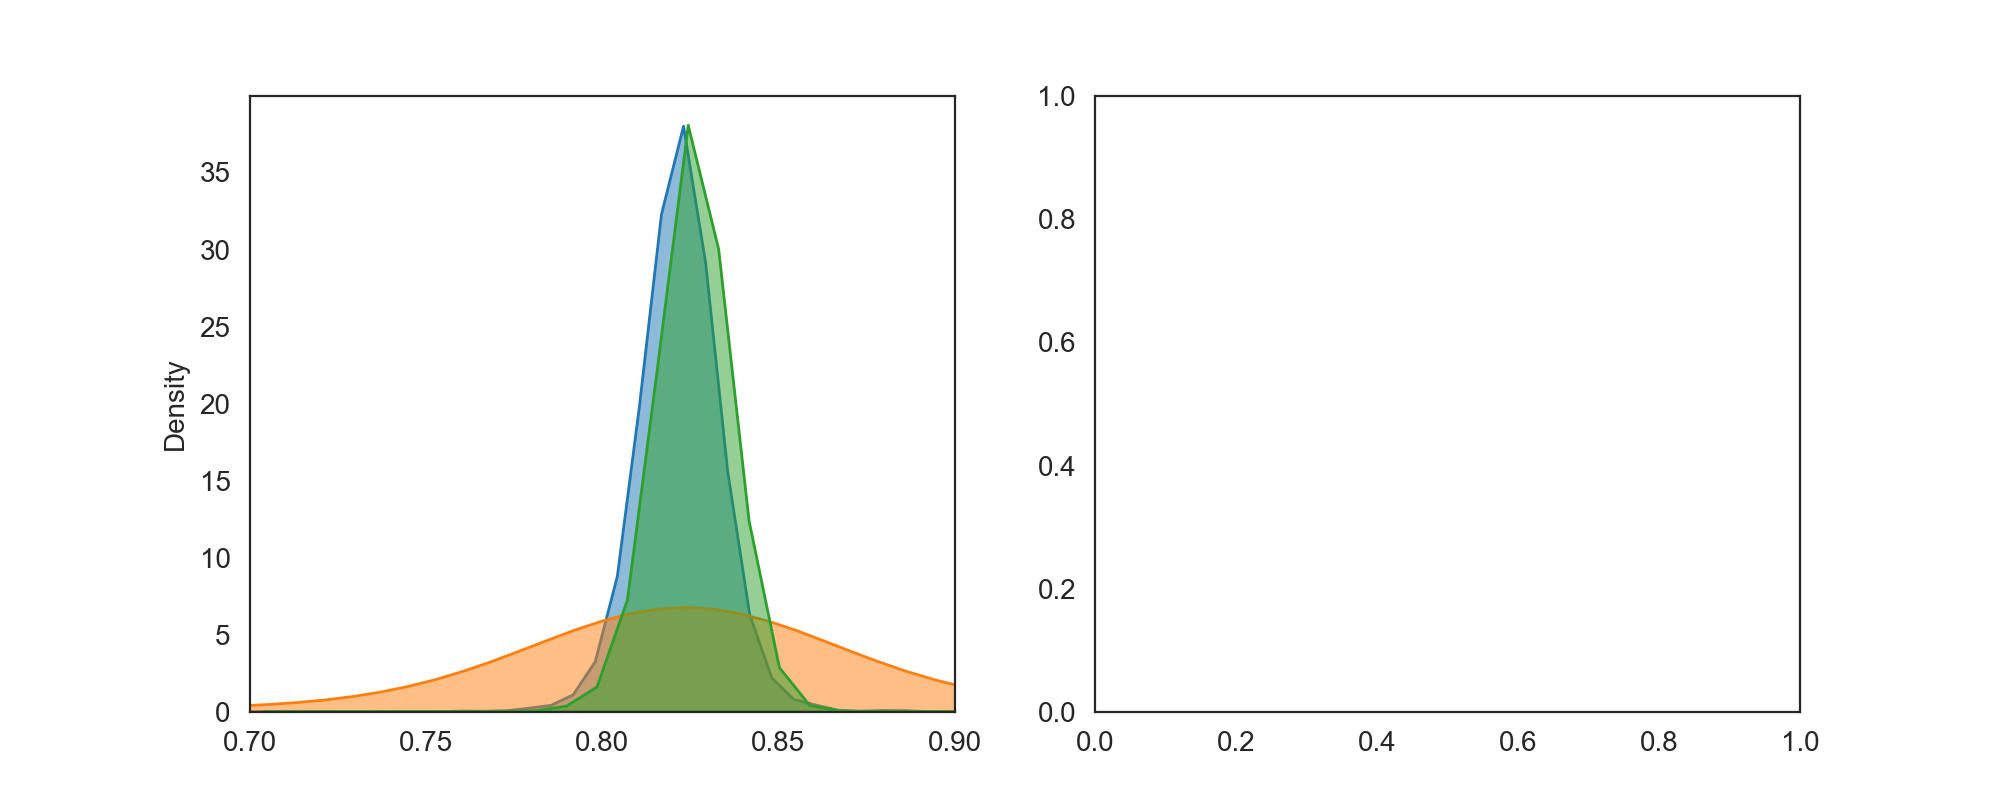

(0.7, 0.9)

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.kdeplot(period_integral_full, ax=ax1, fill=True, alpha=0.5, label="INTEGRAL SPI-ACS")
sns.kdeplot(period_nai_full, ax=ax1, fill=True, alpha=0.5, label="Fermi/GBM, NaI", gridsize=1000)
sns.kdeplot(period_bgo_full, ax=ax1, fill=True, alpha=0.5, label="Fermi/GBM, BGO", )
ax1.set_xlim(0.7, 0.9)

<IPython.core.display.Javascript object>


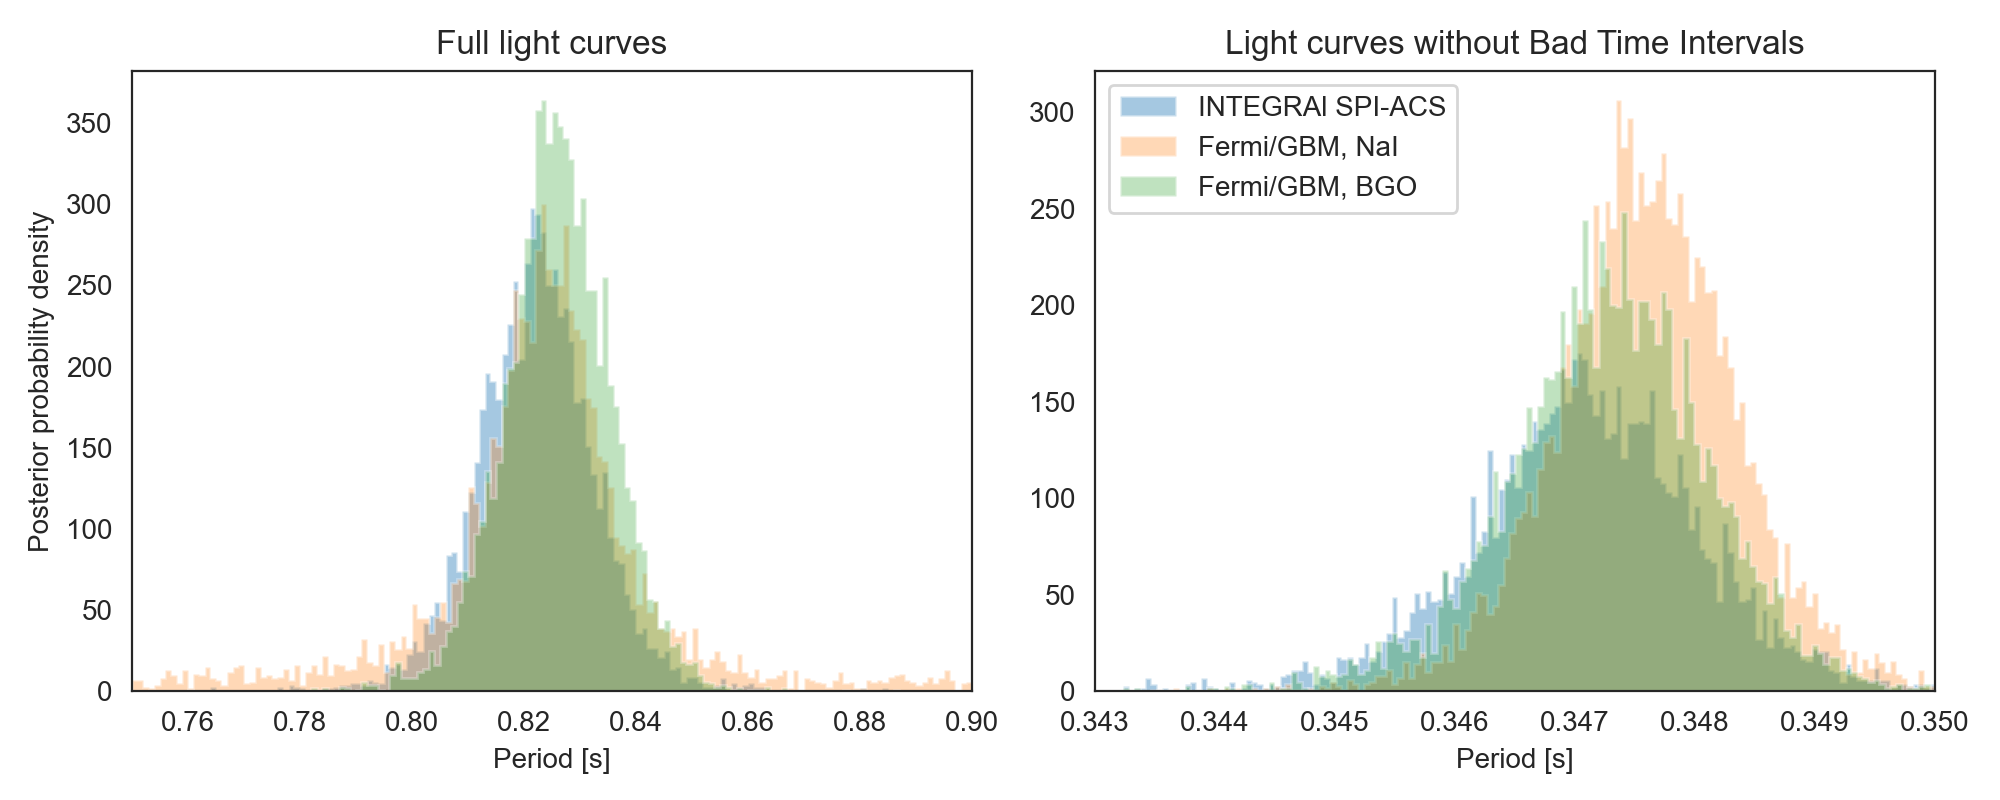

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

nbins = 150
histrange1 = [0.75, 0.9]

ax1.hist(period_integral_full, bins=nbins, alpha=0.4, label="INTEGRAl SPI-ACS", 
         range=histrange1, histtype="stepfilled")
ax1.hist(period_nai_full, bins=nbins, alpha=0.3, label="Fermi/GBM, NaI", 
         range=histrange1, histtype="stepfilled")
ax1.hist(period_bgo_full, bins=nbins, alpha=0.3, label="Fermi/GBM, BGO", 
         range=histrange1, histtype="stepfilled")
ax1.set_xlim(histrange1)
ax1.set_xlabel("Period [s]")
ax1.set_ylabel("Posterior probability density")
ax1.set_title("Full light curves")

histrange2 = [0.343, 0.35]
ax2.hist(period_integral_cutout, bins=nbins, alpha=0.4, label="INTEGRAl SPI-ACS", 
          range=histrange2, histtype="stepfilled")
ax2.hist(period_nai_cutout, bins=nbins, alpha=0.3, label="Fermi/GBM, NaI", 
         range=histrange2, histtype="stepfilled")
ax2.hist(period_bgo_cutout, bins=nbins, alpha=0.3, label="Fermi/GBM, BGO", 
         range=histrange2, histtype="stepfilled")
ax2.set_xlim(histrange2)
ax2.set_xlabel("Period [s]")
ax2.set_title("Light curves without Bad Time Intervals")

ax2.legend()

fig.tight_layout()

fig.savefig(f"{figdir}all_periods.pdf", format="pdf")

## Fermi/GBM NaI Data: DRW Model, Full Data

Let's make some of those plots for the Fermi/GBM Data, NaI detector:

INFO[2023-11-20 15:40:49,316]: make_lightcurve: tseg: 144.99889838695526
INFO[2023-11-20 15:40:49,318]: make_lightcurve: timebin:  2899
INFO[2023-11-20 15:40:49,366]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-20 15:40:49,367]: Checking if light curve is sorted.
INFO[2023-11-20 15:40:49,368]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


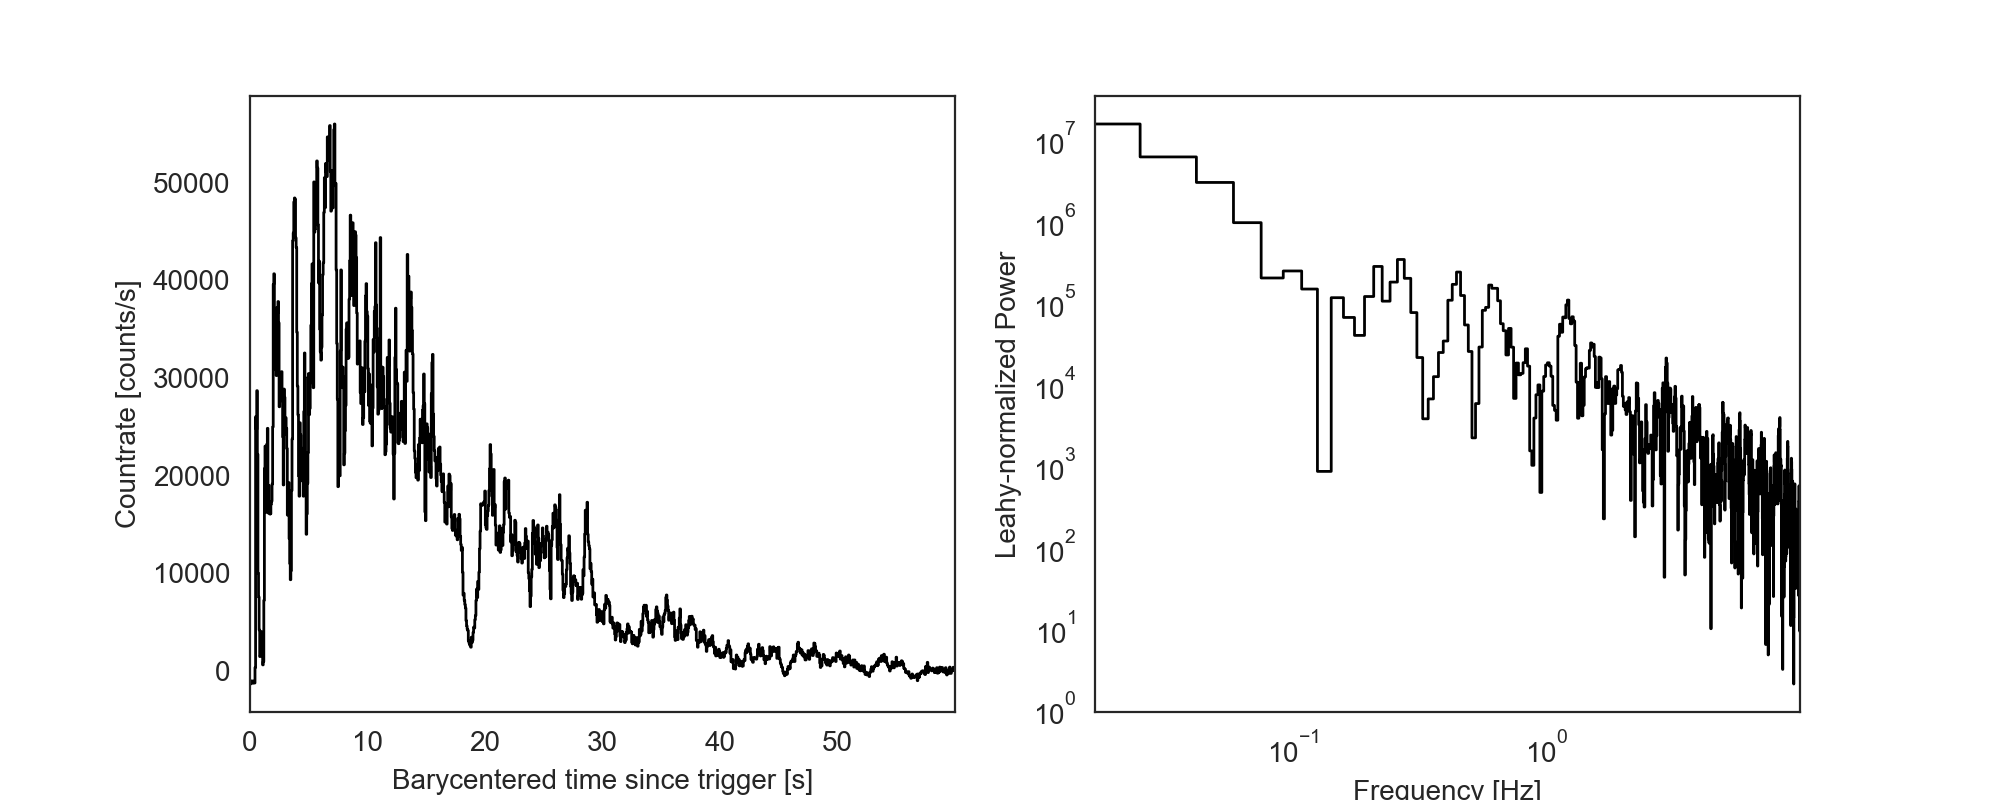

Text(0, 0.5, 'Leahy-normalized Power')

In [4]:
#data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")
#barytime = np.array(data["na_barytime"], dtype=float)
#barytime = barytime
#lc_nai = Lightcurve.make_lightcurve(barytime, dt=0.05)

#minind = lc_nai.time.searchsorted(lc_nai.tstart+24.5)
#maxind = lc_nai.time.searchsorted(lc_nai.tstart + 84.5)
#lc_nai = lc_nai.truncate(start=minind, stop=maxind, method="index")

#mean_bkg = np.mean(lc_nai.counts[-100:])

#lc_nai = Lightcurve(lc_nai.time-lc_nai.time[0], lc_nai.counts-mean_bkg)
#ps_nai = Powerspectrum(lc_nai, norm="leahy")
# read data
data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")

# extract events
barytime = np.array(data["na_barytime"], dtype=float)
barytime = barytime
lc_nai = Lightcurve.make_lightcurve(barytime, dt=0.05)

# truncate light curve
minind = lc_nai.time.searchsorted(lc_nai.tstart+24.5)
maxind = lc_nai.time.searchsorted(lc_nai.tstart + 84.5)
lc_nai = lc_nai.truncate(start=minind, stop=maxind, method="index")

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_nai.dt * lc_nai.counts
counts_obs_corr = lc_nai.counts / (1. - frac_obs) 

# subtract mean background
mean_bkg = np.mean(counts_obs_corr[-100:])

# make light curve and PSD
lc_nai = Lightcurve(lc.time-lc.time[0], counts_obs_corr-mean_bkg)
ps_nai = Powerspectrum(lc, norm="leahy")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_nai.time, lc_nai.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc_nai.time[0], lc_nai.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps_nai.freq, ps_nai.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps_nai.freq[0], ps_nai.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

INFO[2023-11-20 15:41:17,295]: make_lightcurve: tseg: 144.99639451503754
INFO[2023-11-20 15:41:17,295]: make_lightcurve: timebin:  2899
INFO[2023-11-20 15:41:17,331]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-20 15:41:17,332]: Checking if light curve is sorted.
INFO[2023-11-20 15:41:17,333]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


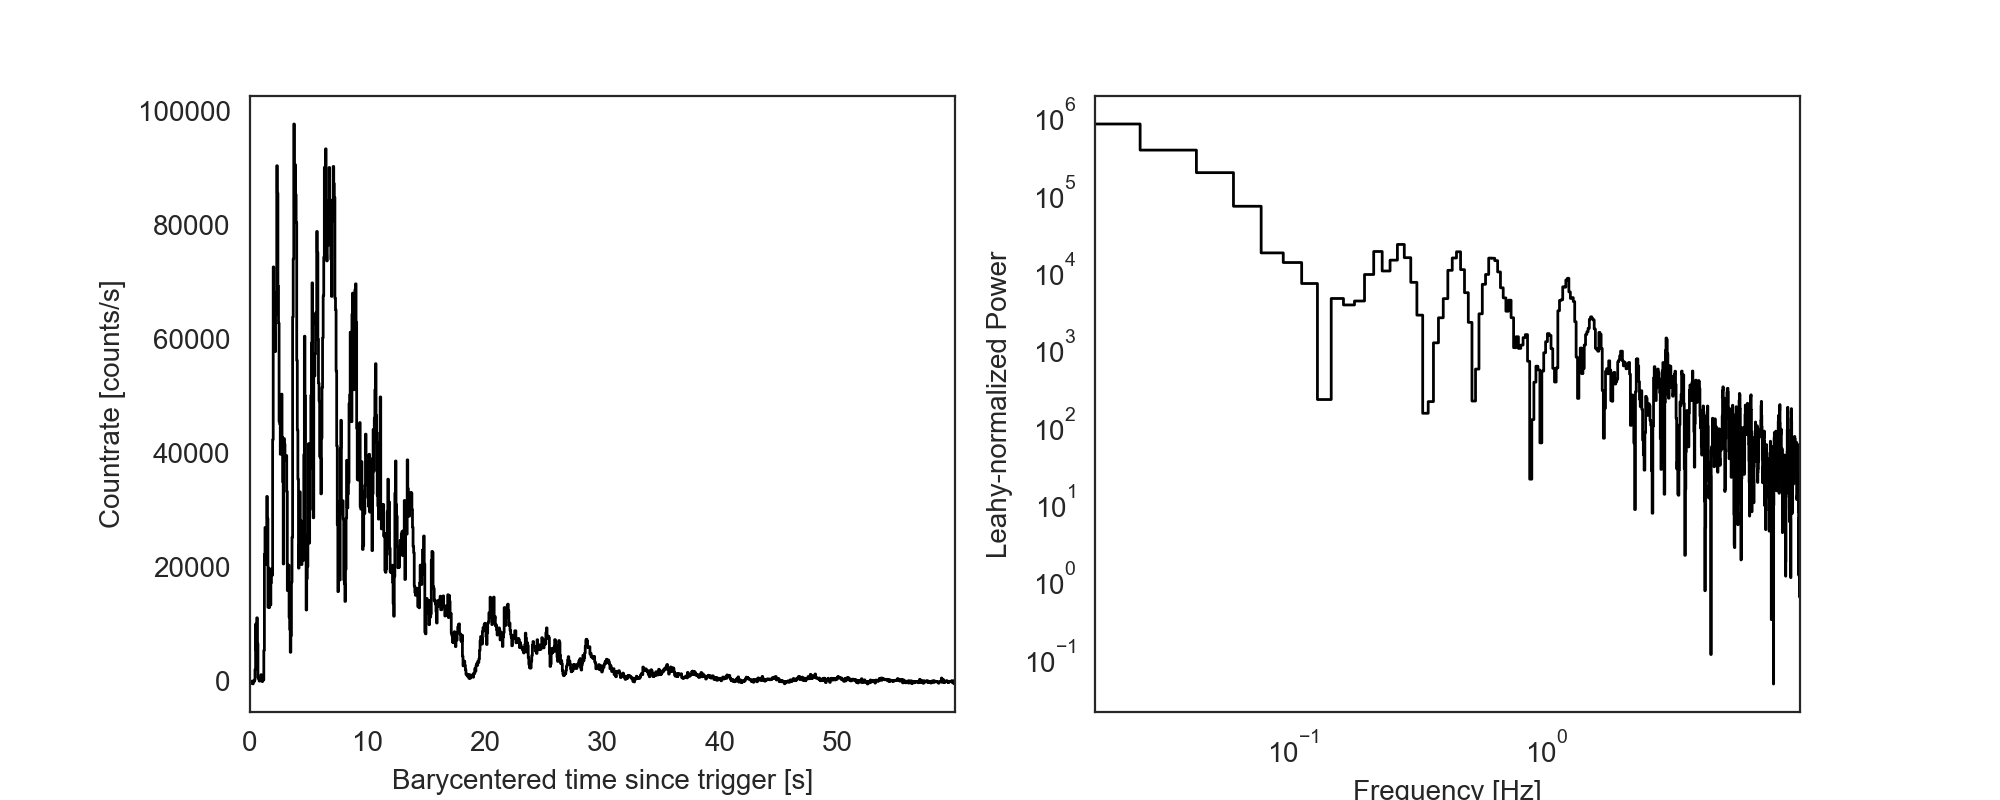

Text(0, 0.5, 'Leahy-normalized Power')

In [6]:
#data = scipy.io.readsav(datadir+"bn230307656_b1_mete.sav")
#barytime = np.array(data["b1_barytime"], dtype=float)
#barytime = barytime
#lc_bgo = Lightcurve.make_lightcurve(barytime, dt=0.05)

#minind = lc_bgo.time.searchsorted(lc_bgo.tstart+24.5)
#maxind = lc_bgo.time.searchsorted(lc_bgo.tstart + 84.5)
#lc_bgo = lc_bgo.truncate(start=minind, stop=maxind, method="index")

#mean_bkg = np.mean(lc_bgo.counts[-100:])

#lc_bgo = Lightcurve(lc_bgo.time-lc_bgo.time[0], lc_bgo.counts-mean_bkg)
#ps_bgo = Powerspectrum(lc_bgo, norm="leahy")
data = scipy.io.readsav(datadir+"bn230307656_b1_mete.sav")

# extract events
barytime = np.array(data["b1_barytime"], dtype=float)
barytime = barytime
lc_bgo = Lightcurve.make_lightcurve(barytime, dt=0.05)

# truncate light curve
minind = lc_bgo.time.searchsorted(lc_bgo.tstart+24.5)
maxind = lc_bgo.time.searchsorted(lc_bgo.tstart + 84.5)
lc_bgo = lc_bgo.truncate(start=minind, stop=maxind, method="index")

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_bgo.dt * lc_bgo.counts
counts_obs_corr = lc_bgo.counts / (1. - frac_obs) 

# subtract mean background
mean_bkg = np.mean(counts_obs_corr[-100:])

# make light curve and PSD
lc_bgo = Lightcurve(lc_bgo.time-lc_bgo.time[0], counts_obs_corr-mean_bkg)
ps_bgo = Powerspectrum(lc_bgo, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_bgo.time, lc_bgo.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps_bgo.freq, ps_bgo.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps_bgo.freq[0], ps_bgo.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

### Periodograms for all three Light curves

<IPython.core.display.Javascript object>


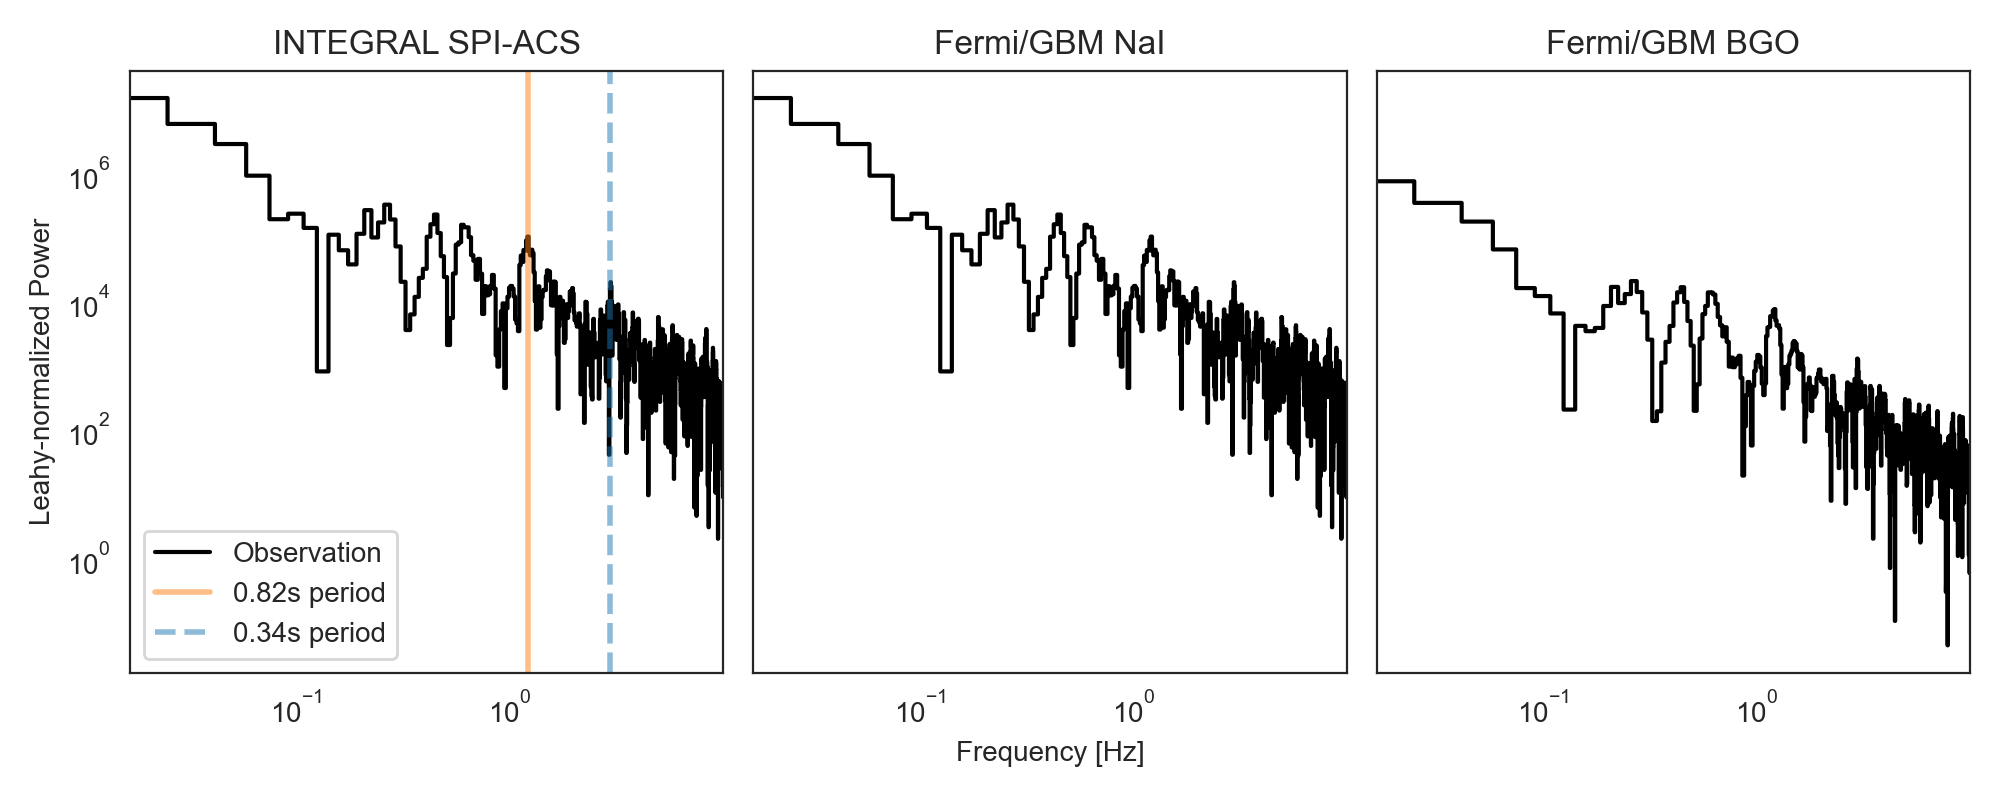

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4), sharey=True, sharex=True)

ax1.loglog(ps.freq, ps.power, ds="steps-mid", color="black", label="Observation")
ax1.axvline(1.0/0.82, lw=2, color=sns.color_palette()[1], alpha=0.5, label="0.82s period")
ax1.axvline(1.0/0.34, lw=2, ls="dashed", color=sns.color_palette()[0], alpha=0.5, label="0.34s period")
ax1.set_title("INTEGRAL SPI-ACS")
ax2.set_title("Fermi/GBM NaI")
ax3.set_title("Fermi/GBM BGO")
ax2.loglog(ps_nai.freq, ps_nai.power, ds="steps-mid", color="black")
ax3.loglog(ps_bgo.freq, ps_bgo.power, ds="steps-mid", color="black")

ax1.set_xlim(ps.freq[0], ps.freq[-1])
ax1.set_ylabel("Leahy-normalized Power")
ax1.legend()
ax2.set_xlabel("Frequency [Hz]")
plt.tight_layout()

fig.savefig(f"{figdir}all_psd.pdf", format="pdf")

In [31]:
with open(datadir+"fermi_nai_drw_qpo_deadtimecorr_res.pkl", "rb") as f:
    res_nai_qporn = pickle.load(f)

with open(datadir+"fermi_bgo_drw_qpo_deadtimecorr_res.pkl", "rb") as f:
    res_bgo_qporn = pickle.load(f)

In [32]:
samples_nai_qporn = resample_posterior(res_nai_qporn, rkey=random.PRNGKey(12553))
samples_bgo_qporn = resample_posterior(res_bgo_qporn, rkey=random.PRNGKey(12553))

#df_qporn_cutout = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_qporn_cutout["log_A"],
#                      r"$t_0$": samples_qporn_cutout["t0"],
#                      r"$\log(\tau_\mathrm{rise})$":samples_qporn_cutout["log_sig1"],
#                      r"$\log(\tau_\mathrm{fall})$": samples_qporn_cutout["log_sig2"],
#                      r"$\log(A_{\mathrm{rn}})$": samples_qporn_cutout["log_arn"],
#                      r"$\log(c_\mathrm{rn})$": samples_qporn_cutout["log_crn"],
#                      r"$\log(\nu_c)$":samples_qporn_cutout["log_freq"],
#                      r"$\log(A_\mathrm{QPO})$":samples_qporn_cutout["log_aqpo"],
#                      r"$\log(c_\mathrm{QPO})$": samples_qporn_cutout["log_cqpo"]}
#                              )

In [33]:
freq_nai = np.exp(samples_nai_qporn["log_freq"])
freq_bgo = np.exp(samples_bgo_qporn["log_freq"])

period_nai = 1./freq_nai
period_bgo = 1./freq_bgo

qual_nai = freq_nai / np.exp(samples_nai_qporn["log_cqpo"])
qual_bgo = freq_bgo / np.exp(samples_bgo_qporn["log_cqpo"])

<IPython.core.display.Javascript object>


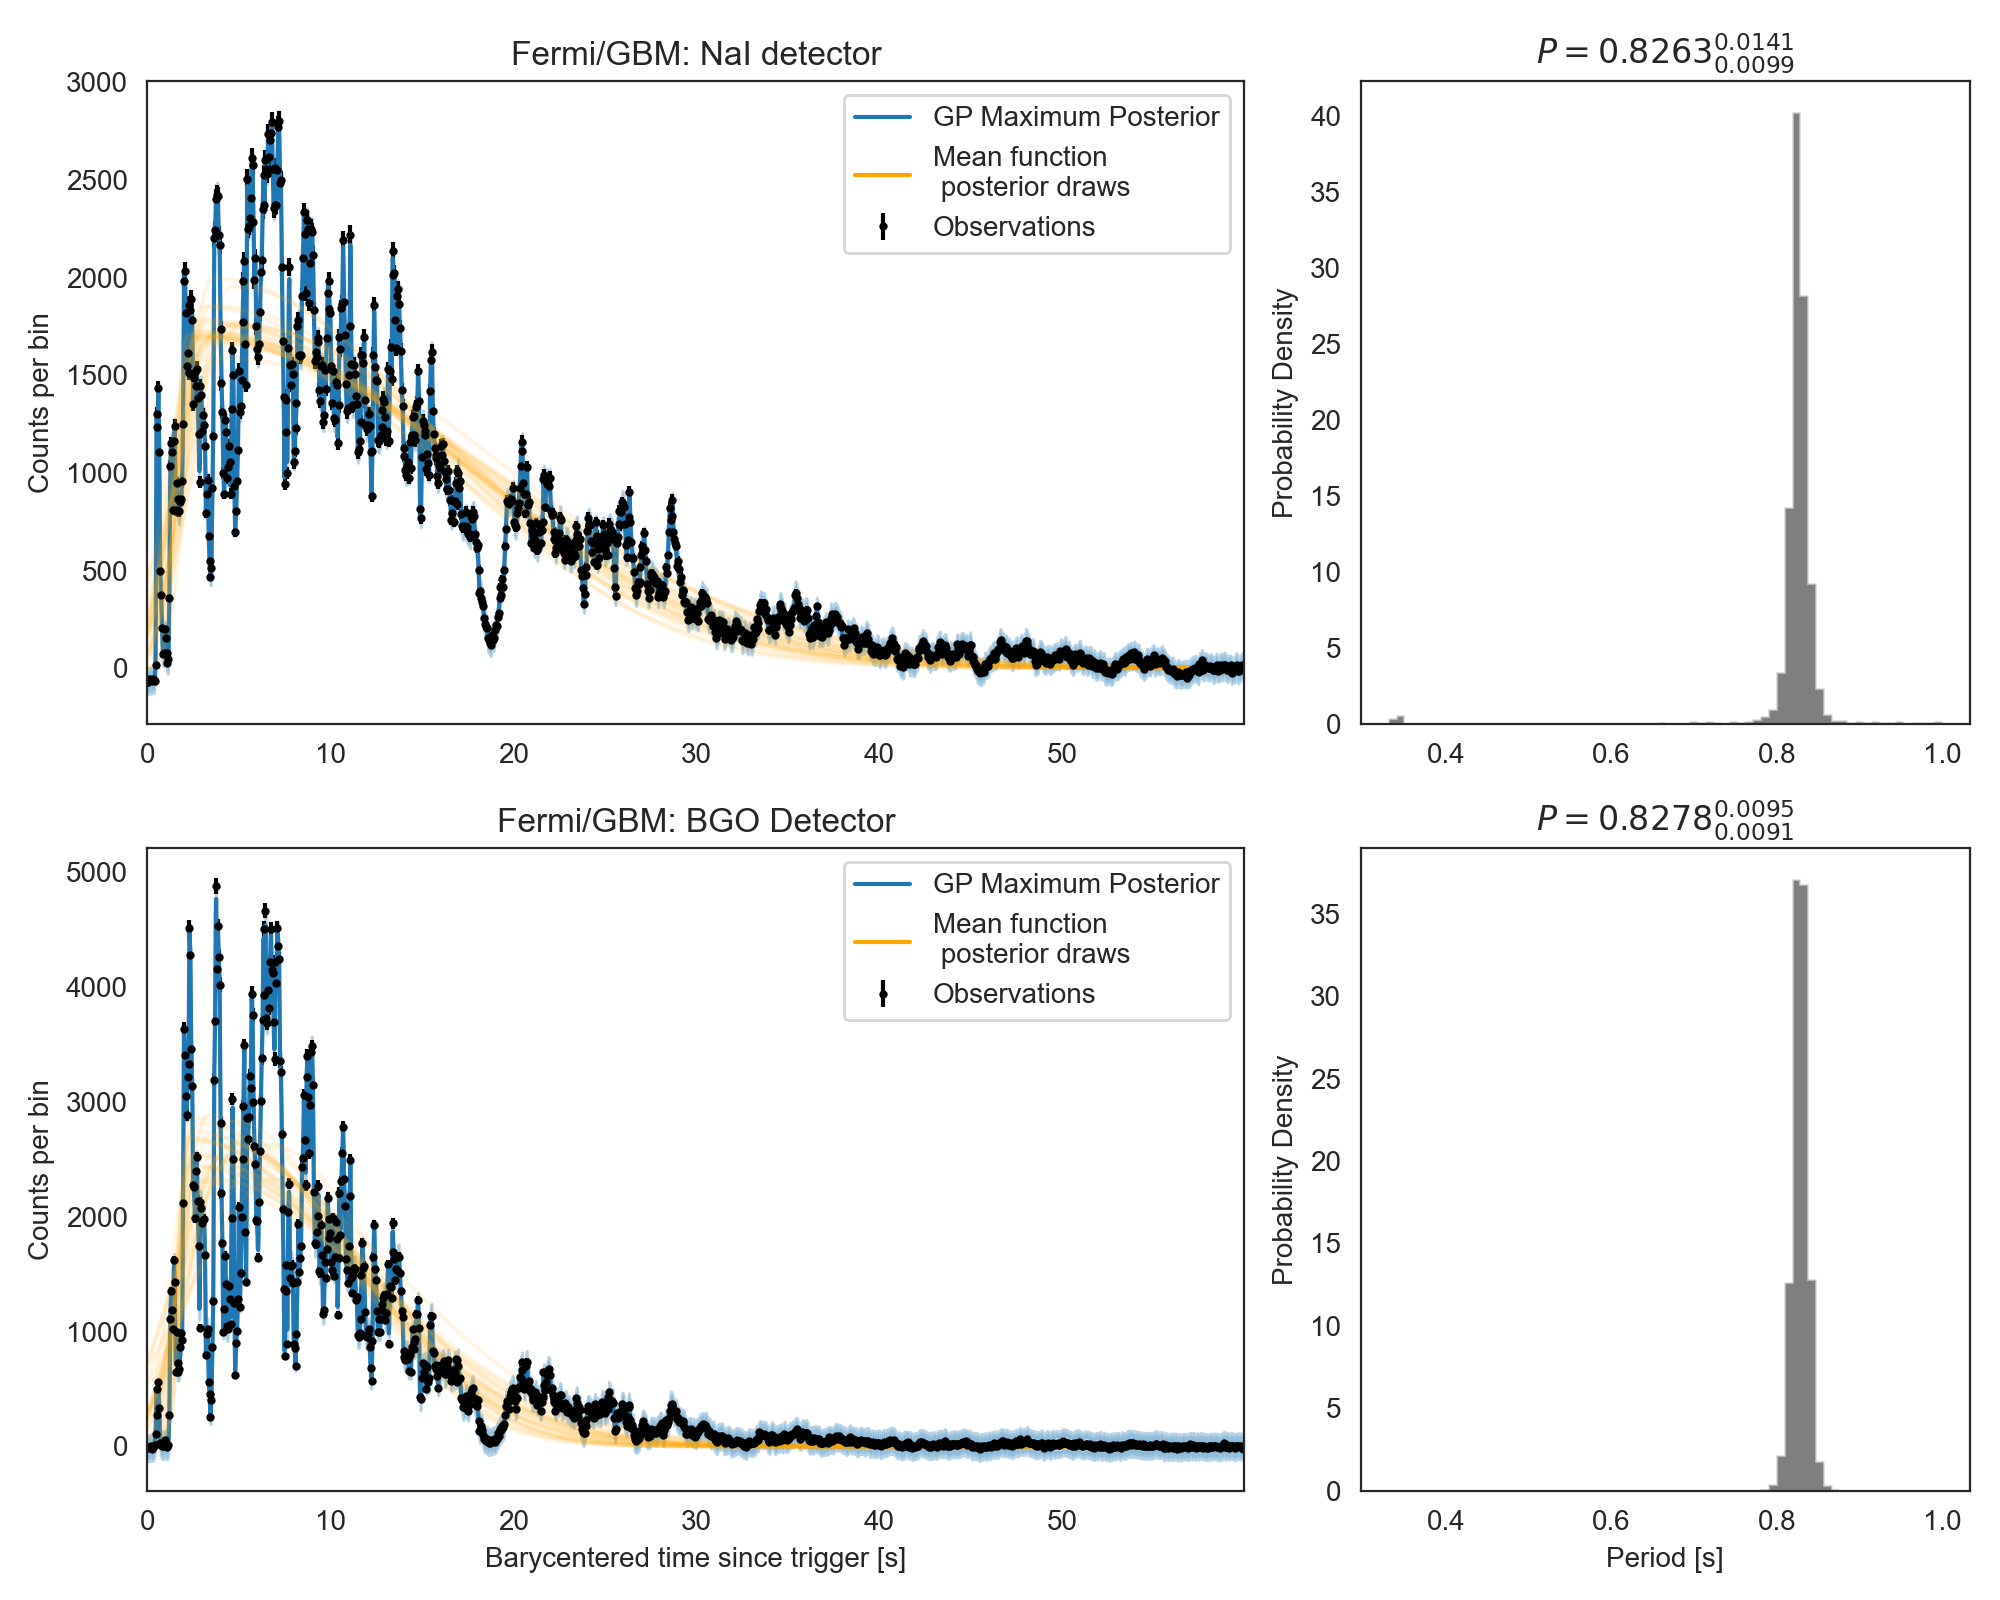

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...
Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), width_ratios=[1.8, 1.0])

axes = np.hstack(axes)

mean_type = "skew_gaussian"
axes[0] = plot_posterior_predictive(lc_nai, res_nai_qporn, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[0], rkey=None)


axes[2] = plot_posterior_predictive(lc_bgo, res_bgo_qporn, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[2], rkey=None)

axes[0].set_xlim(lc_nai.time[0], lc_nai.time[-1])
#axes[0].set_xlabel("Barycentered time since trigger [s]")
axes[0].set_ylabel("Counts per bin")
axes[0].set_title("Fermi/GBM: NaI detector")

axes[2].set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
axes[2].set_xlabel("Barycentered time since trigger [s]")
axes[2].set_ylabel("Counts per bin")
axes[2].set_title("Fermi/GBM: BGO Detector")


histrange = [0.33, 1.0]
axes[1].hist(period_nai, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange);
#axes[1].set_xlabel("Period [s]")
axes[1].set_ylabel("Probability Density")

perc1 = np.percentile(period_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err1 = [perc1[1] - perc1[0], perc1[2]-perc1[1]]

axes[1].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc1[1], err1[1], err1[0]))

#histrange2 = [0.2,0.3]
axes[3].hist(period_bgo, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange);
axes[3].set_xlabel("Period [s]")
axes[3].set_ylabel("Probability Density")

perc2 = np.percentile(period_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err2 = [perc2[1] - perc2[0], perc2[2]-perc2[1]]

axes[3].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc2[1], err2[1], err2[0]))


fig.tight_layout()

fig.savefig(f"{figdir}fermi_both_drw_qpo_postpred.pdf", format="pdf")

<IPython.core.display.Javascript object>


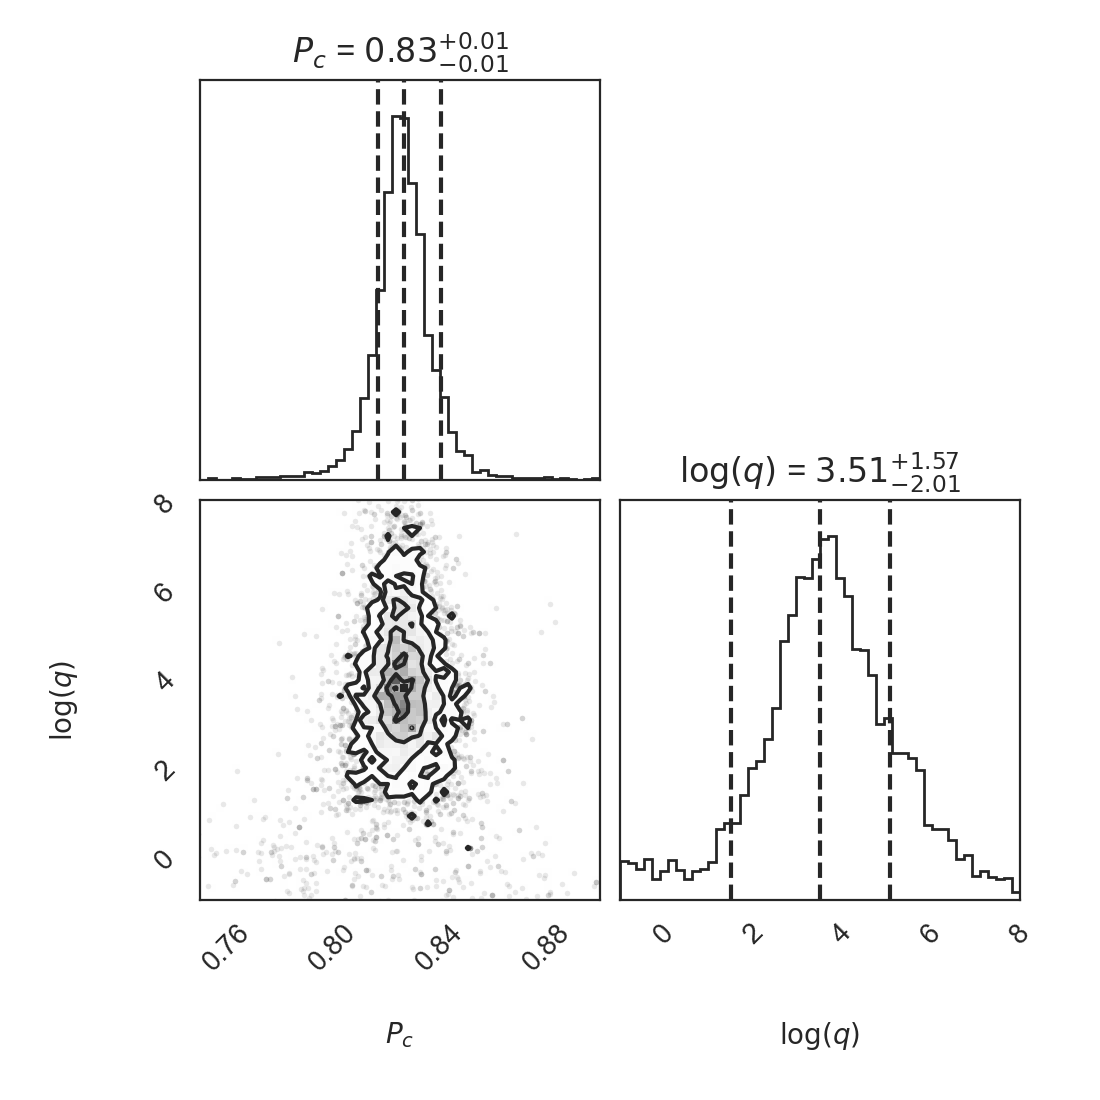

In [35]:
#qual = np.exp(samples_qpo["log_freq"])/np.exp(samples_qpo["log_cqpo"])
#perc = np.percentile(qual, [16, 50, 84])
#print(perc)
#print(perc[2]-perc[1])
#print(perc[1]-perc[0])

perc_nai_freq = np.percentile(freq_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_freq = [perc_nai_freq[1] - perc_nai_freq[0], perc_nai_freq[2]-perc_nai_freq[1]]

perc_nai_qual = np.percentile(qual_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_qual = [perc_nai_qual[1] - perc_nai_qual[0], perc_nai_qual[2]-perc_nai_qual[1]]
corner.corner(np.array([period_nai, np.log(qual_nai)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.75, 0.9], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



In [36]:
np.exp(2.37)

10.697392284111054

In [37]:
np.exp(3.34)

28.21912670540861

<IPython.core.display.Javascript object>


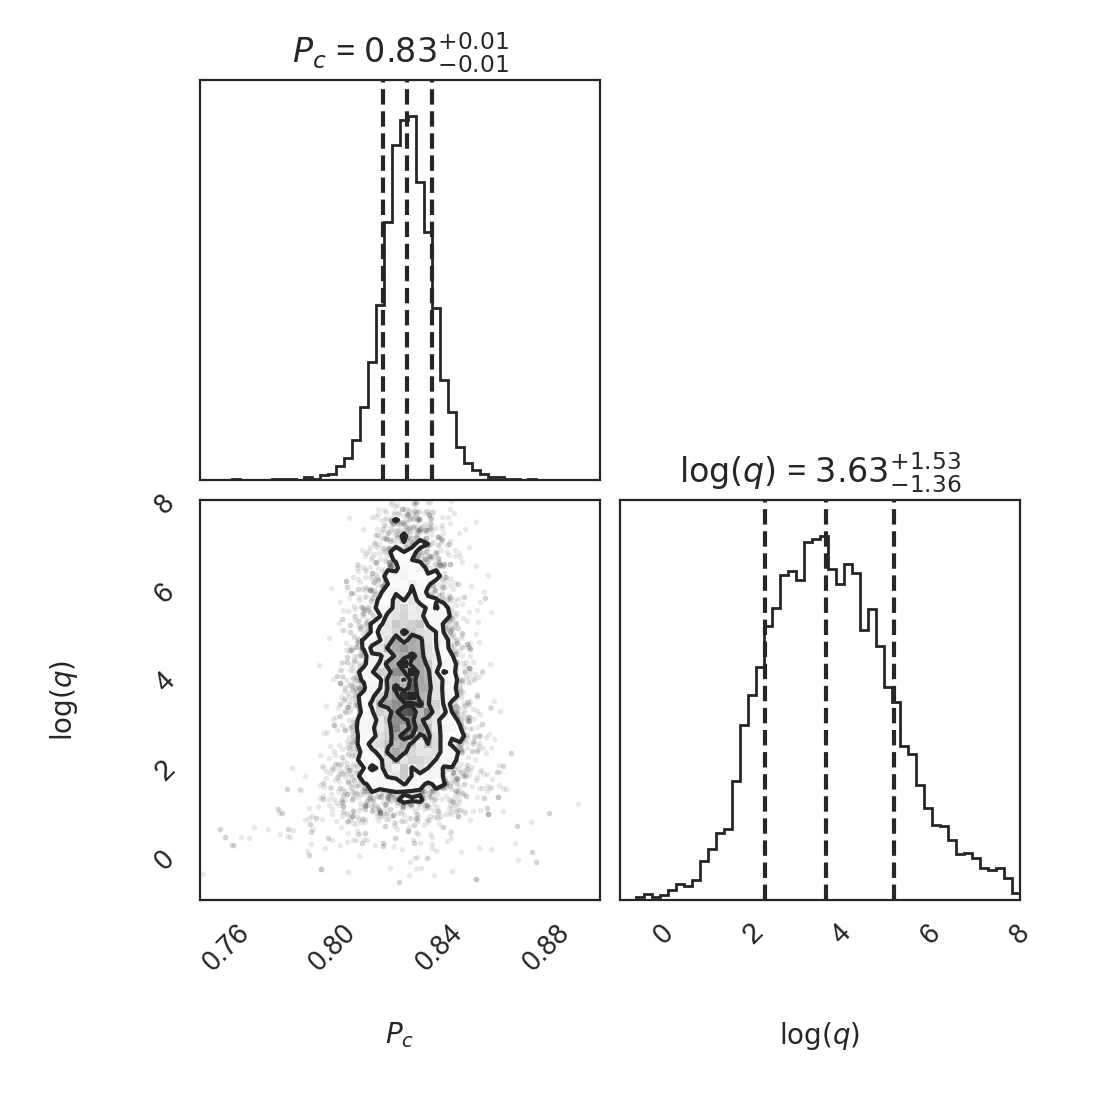

In [38]:

perc_bgo_freq = np.percentile(freq_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_freq = [perc_bgo_freq[1] - perc_bgo_freq[0], perc_bgo_freq[2]-perc_bgo_freq[1]]

perc_bgo_qual = np.percentile(qual_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err_bgo_qual = [perc_bgo_qual[1] - perc_bgo_qual[0], perc_bgo_qual[2]-perc_bgo_qual[1]]
corner.corner(np.array([period_bgo, np.log(qual_bgo)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.75, 0.9], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



## Fermi Data: DRW, Cutouts

In [56]:
## NaI Detectors
data = scipy.io.readsav(datadir+"bn230307656_na_mete.sav")
barytime = np.array(data["na_barytime"], dtype=float)

tstart = barytime[0]

minind = barytime.searchsorted(barytime[0]+24.5)
maxind = barytime.searchsorted(barytime[0] + 84.5)

lc = Lightcurve.make_lightcurve(barytime[minind:maxind], dt=0.05)

cutout_minind = lc.time.searchsorted(tstart + 24.5 + 4.0)
cutout_maxind = lc.time.searchsorted(tstart + 24.5 + 8.0)

t1 = lc.time[:cutout_minind]
t2 = lc.time[cutout_maxind:]

time = np.hstack([t1, t2])

c1 = lc.counts[:cutout_minind]
c2 = lc.counts[cutout_maxind:]

counts = np.hstack([c1, c2])

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_nai.dt * counts
counts_obs_corr = counts / (1. - frac_obs) 

mean_bkg = np.mean(counts[-100:])

lc_nai = Lightcurve(time - time[0], counts_obs_corr-mean_bkg)

print("made NaI light curve")

## BGO Detectors

data = scipy.io.readsav(datadir+"bn230307656_b1_mete.sav")
barytime = np.array(data["b1_barytime"], dtype=float)

tstart = barytime[0]

minind = barytime.searchsorted(barytime[0] + 24.5)
maxind = barytime.searchsorted(barytime[0] + 84.5)

lc = Lightcurve.make_lightcurve(barytime[minind:maxind], dt=0.05)

cutout_minind = lc.time.searchsorted(tstart + 24.5 + 4.0)
cutout_maxind = lc.time.searchsorted(tstart + 24.5 + 8.0)
print(cutout_minind)
print(cutout_maxind)

t1 = lc.time[:cutout_minind]
t2 = lc.time[cutout_maxind:]

time = np.hstack([t1, t2])

c1 = lc.counts[:cutout_minind]
c2 = lc.counts[cutout_maxind:]

counts_bgo = np.hstack([c1, c2])

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc_nai.dt * counts_bgo
counts_obs_corr = counts_bgo / (1. - frac_obs) 

mean_bkg = np.mean(counts[-100:])

lc_bgo = Lightcurve(time-lc.time[0], counts_obs_corr-mean_bkg)


INFO[2023-11-07 14:54:34,665]: make_lightcurve: tseg: 59.99947488307953
INFO[2023-11-07 14:54:34,666]: make_lightcurve: timebin:  1199
INFO[2023-11-07 14:54:34,692]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-07 14:54:34,693]: Checking if light curve is sorted.
INFO[2023-11-07 14:54:34,694]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation
INFO[2023-11-07 14:54:34,709]: make_lightcurve: tseg: 59.99704682826996
INFO[2023-11-07 14:54:34,710]: make_lightcurve: timebin:  1199
INFO[2023-11-07 14:54:34,733]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-07 14:54:34,734]: Checking if light curve is sorted.
INFO[2023-11-07 14:54:34,735]: Computing the bin time ``dt``. This can take time. 

made NaI light curve
80
160


<IPython.core.display.Javascript object>


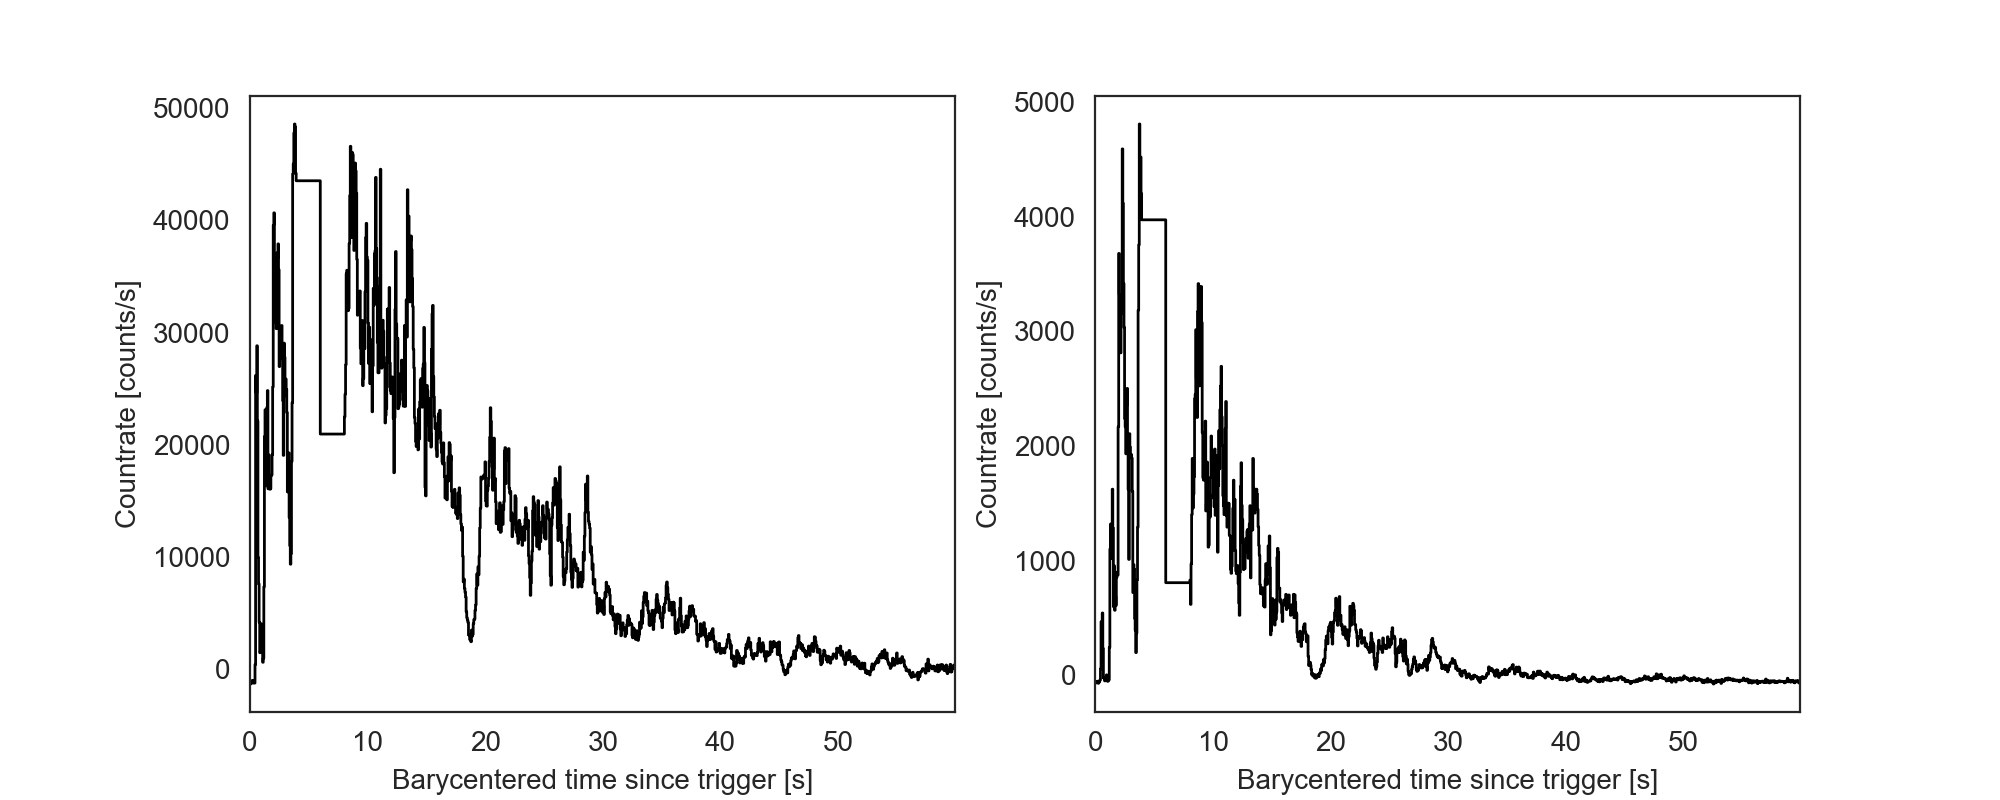

Text(0, 0.5, 'Countrate [counts/s]')

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc_nai.time, lc_nai.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.plot(lc_bgo.time, lc_bgo.counts, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(lc_nai.time[0], lc_nai.time[-1])
ax2.set_xlabel("Barycentered time since trigger [s]")
ax2.set_ylabel("Countrate [counts/s]")


In [58]:
with open(datadir+"fermi_nai_drw_qpo_cutout_deadtimecorr_res.pkl", "rb") as f:
    res_nai_qporn = pickle.load(f)

with open(datadir+"fermi_bgo_drw_qpo_cutout_deadtimecorr_res.pkl", "rb") as f:
    res_bgo_qporn = pickle.load(f)

In [59]:
samples_nai_qporn = resample_posterior(res_nai_qporn, rkey=random.PRNGKey(12553))
samples_bgo_qporn = resample_posterior(res_bgo_qporn, rkey=random.PRNGKey(12553))

freq_nai = np.exp(samples_nai_qporn["log_freq"])
freq_bgo = np.exp(samples_bgo_qporn["log_freq"])

period_nai = 1./freq_nai
period_bgo = 1./freq_bgo

c_nai = np.exp(samples_nai_qporn["log_cqpo"])
c_bgo = np.exp(samples_bgo_qporn["log_cqpo"])

<IPython.core.display.Javascript object>


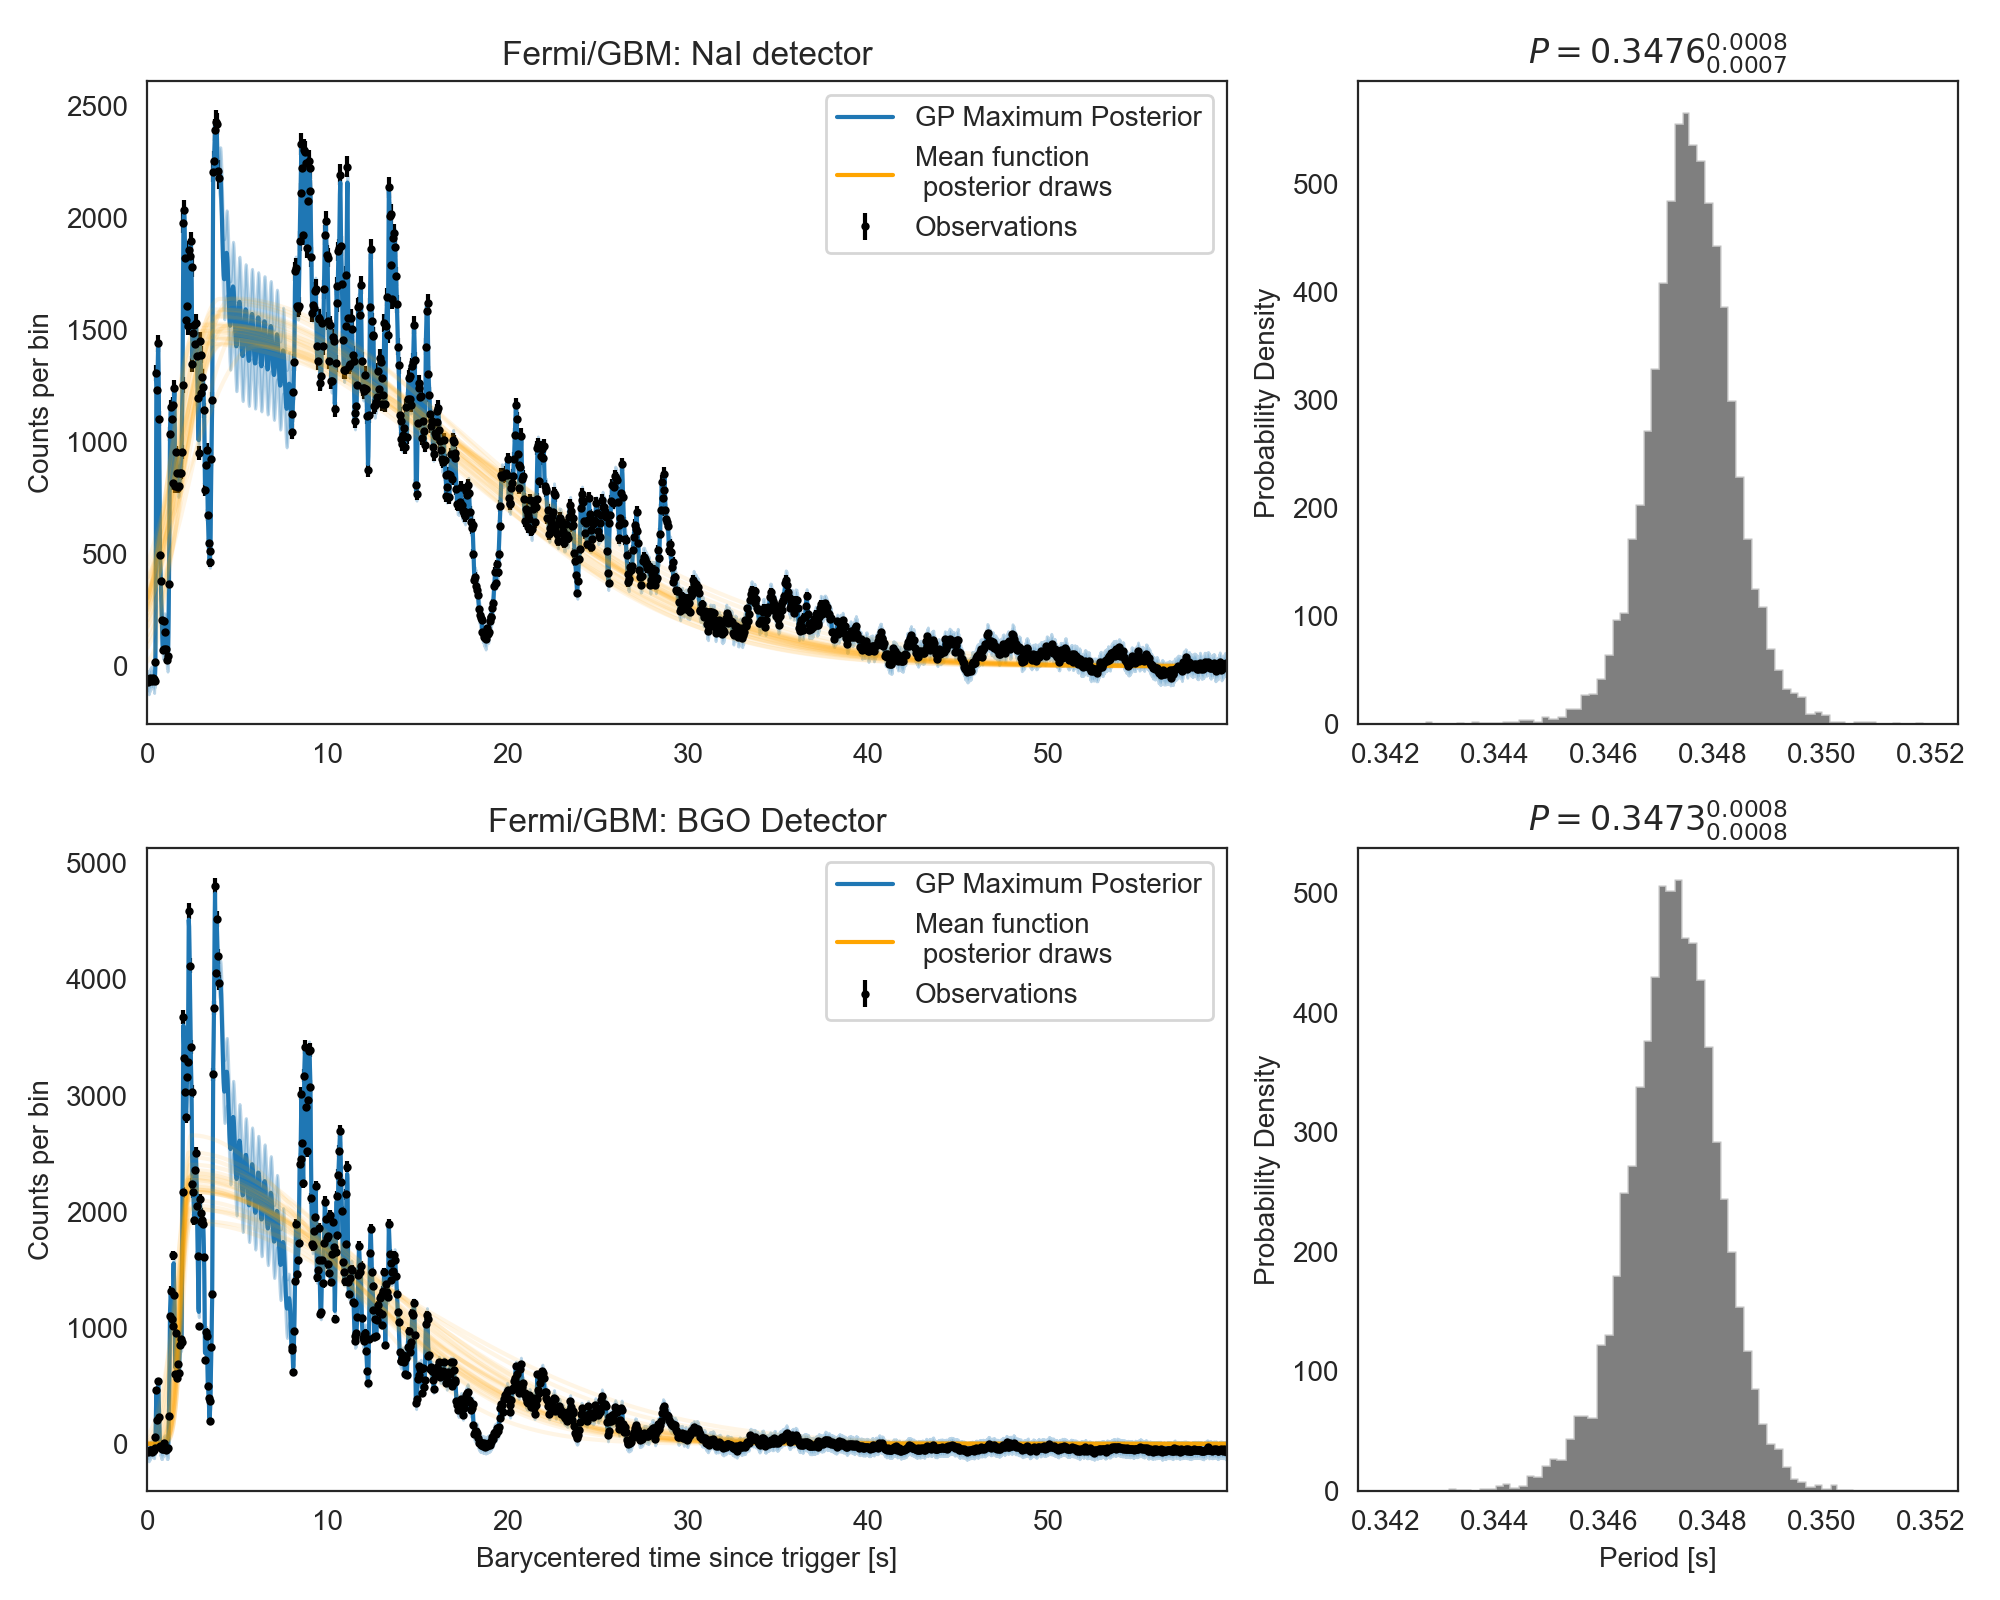

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...
Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


In [60]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), width_ratios=[1.8, 1.0])

axes = np.hstack(axes)

axes[0] = plot_posterior_predictive(lc_nai, res_nai_qporn, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[0], rkey=None)


axes[2] = plot_posterior_predictive(lc_bgo, res_bgo_qporn, "QPO_plus_RN", mean_type, 
                               nmean=25, ngrid=3000, ax=axes[2], rkey=None)

axes[0].set_xlim(lc_nai.time[0], lc_nai.time[-1])
#axes[0].set_xlabel("Barycentered time since trigger [s]")
axes[0].set_ylabel("Counts per bin")
axes[0].set_title("Fermi/GBM: NaI detector")

axes[2].set_xlim(lc_bgo.time[0], lc_bgo.time[-1])
axes[2].set_xlabel("Barycentered time since trigger [s]")
axes[2].set_ylabel("Counts per bin")
axes[2].set_title("Fermi/GBM: BGO Detector")


histrange = [0.342, 0.352]
axes[1].hist(period_nai, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange);
#axes[1].set_xlabel("Period [s]")
axes[1].set_ylabel("Probability Density")

perc1 = np.percentile(period_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err1 = [perc1[1] - perc1[0], perc1[2]-perc1[1]]

axes[1].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc1[1], err1[1], err1[0]))

#histrange2 = [0.2,0.3]
axes[3].hist(period_bgo, bins=70, histtype="stepfilled", alpha=0.5, 
         color="black", density=True, range=histrange);
axes[3].set_xlabel("Period [s]")
axes[3].set_ylabel("Probability Density")

perc2 = np.percentile(period_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err2 = [perc2[1] - perc2[0], perc2[2]-perc2[1]]

axes[3].set_title(r"$P = {{{0:.4f}}}^{{{1:.4f}}}_{{{2:.4f}}}$".format(perc2[1], err2[1], err2[0]))


fig.tight_layout()

fig.savefig(f"{figdir}fermi_both_drw_qpo_cutout_postpred.pdf", format="pdf")

In [62]:
import corner

In [24]:
qual_nai = freq_nai /c_nai
qual_bgo = freq_bgo /c_bgo

<IPython.core.display.Javascript object>


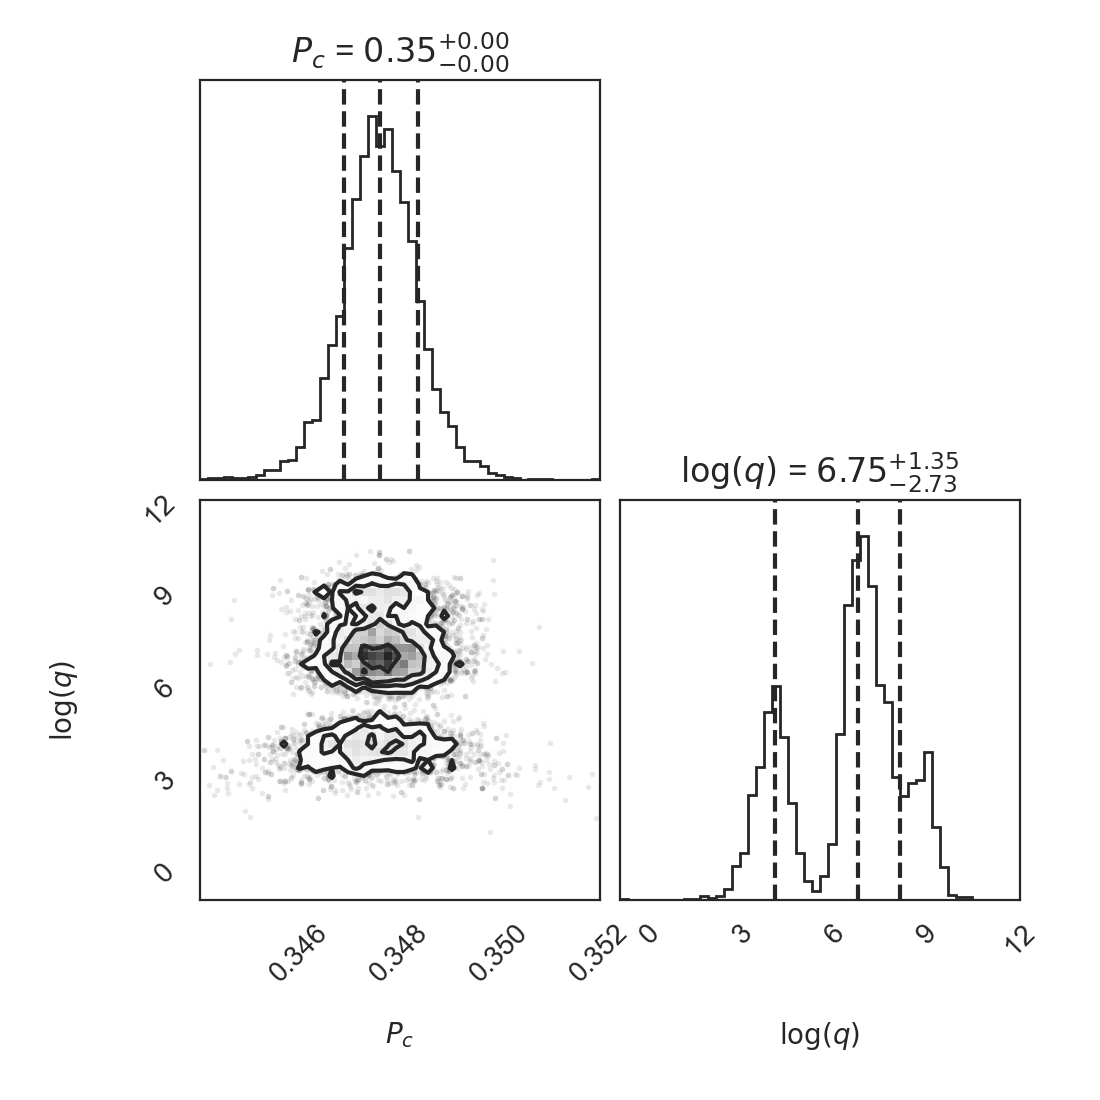

<IPython.core.display.Javascript object>


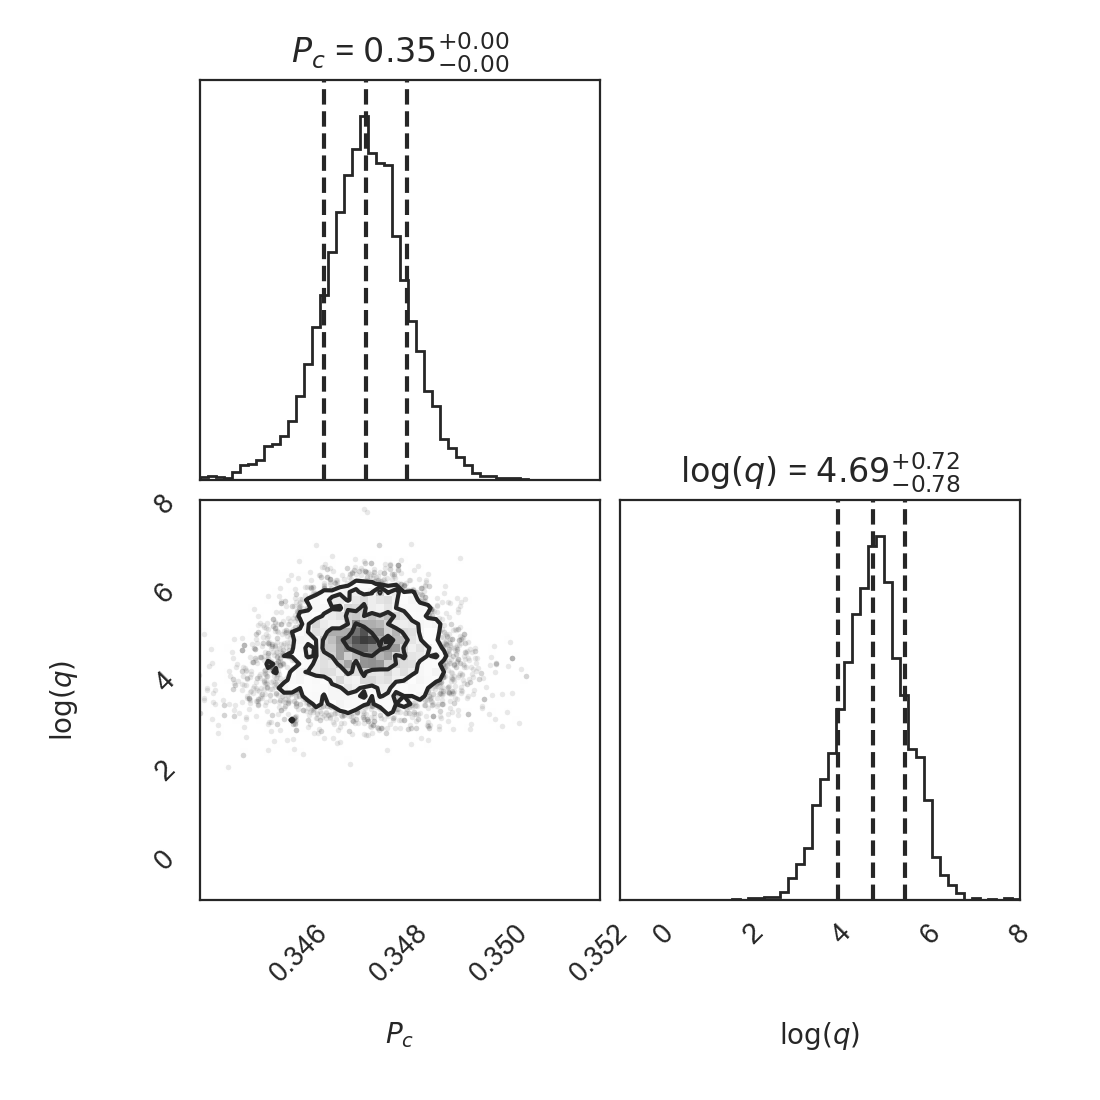

In [25]:
#qual = np.exp(samples_qpo["log_freq"])/np.exp(samples_qpo["log_cqpo"])
#perc = np.percentile(qual, [16, 50, 84])
#print(perc)
#print(perc[2]-perc[1])
#print(perc[1]-perc[0])

perc_nai_freq = np.percentile(freq_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_freq = [perc_nai_freq[1] - perc_nai_freq[0], perc_nai_freq[2]-perc_nai_freq[1]]

perc_nai_qual = np.percentile(qual_nai, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_qual = [perc_nai_qual[1] - perc_nai_qual[0], perc_nai_qual[2]-perc_nai_qual[1]]
corner.corner(np.array([period_nai, np.log(qual_nai)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.344, .352], [-1, 12]], labels=[r"$P_c$", r"$\log(q)$"]);


perc_bgo_freq = np.percentile(freq_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err_nai_freq = [perc_bgo_freq[1] - perc_bgo_freq[0], perc_bgo_freq[2]-perc_bgo_freq[1]]

perc_bgo_qual = np.percentile(qual_bgo, [50-(68.5/2), 50, 50+(68.5/2)])
err_bgo_qual = [perc_bgo_qual[1] - perc_bgo_qual[0], perc_bgo_qual[2]-perc_bgo_qual[1]]
corner.corner(np.array([period_bgo, np.log(qual_bgo)]).T, bins=50, quantiles=[0.16, 0.5, 0.84],
              title_quantiles=[0.16, 0.5, 0.84],show_titles=True,
              range=[[0.344, 0.352], [-1, 8]], labels=[r"$P_c$", r"$\log(q)$"]);



In [26]:
np.exp(2)

7.38905609893065

<IPython.core.display.Javascript object>


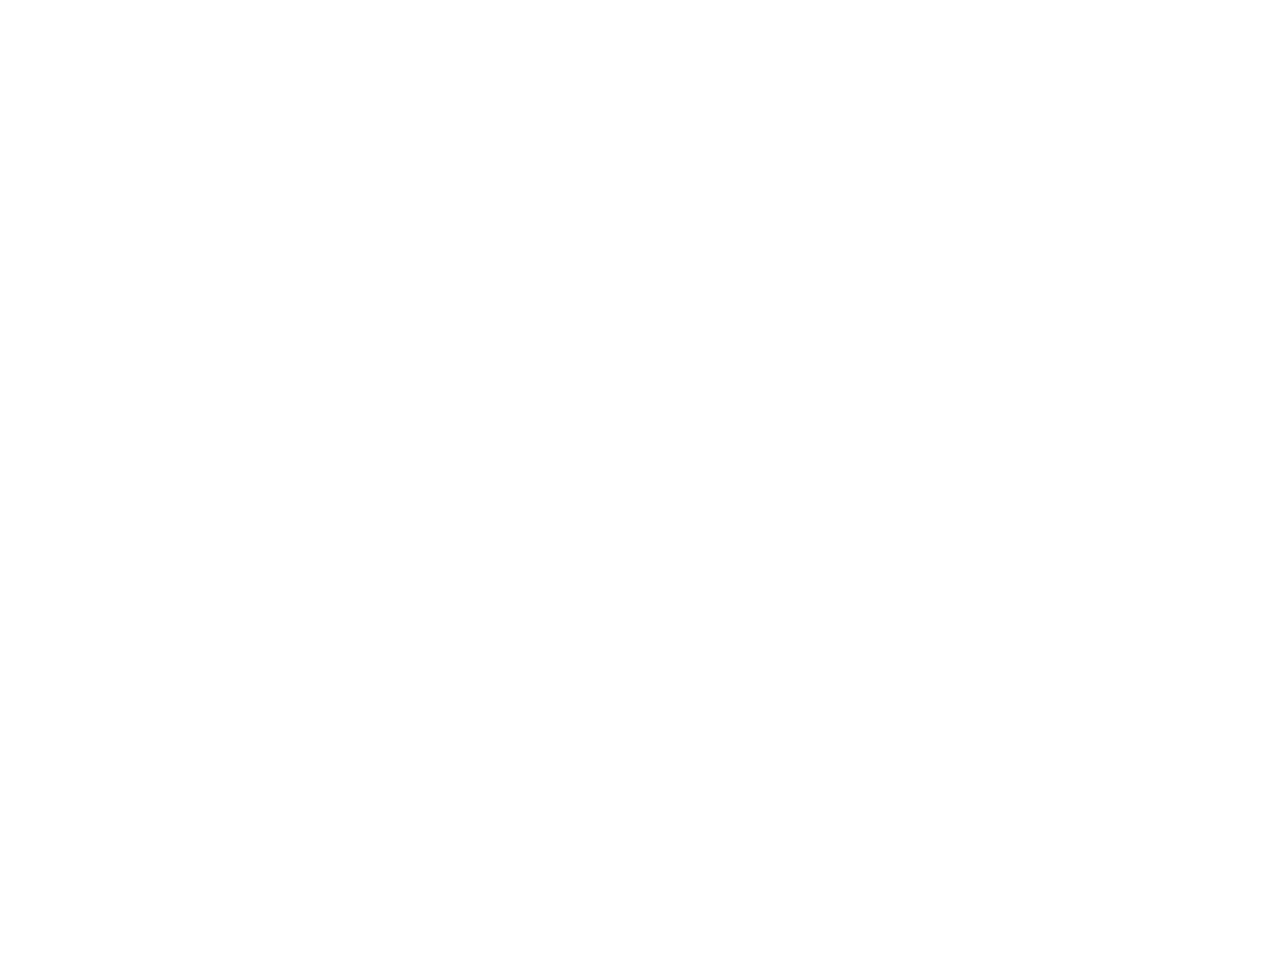

NameError: name 'q_nai' is not defined

In [27]:
plt.figure()
plt.hist(np.log(q_nai), bins=200);

In [ ]:
corner.corner(np.array([freq_nai, c_nai]).T)

## INTEGRAL: CARMA(2,1) Model

Let's make some plots for the CARMA(2,1) model:

In [ ]:
from tinygp.kernels.quasisep import CARMA

def get_max_posterior_parameters(res):
    """
    Returns the optimal parameters for the model based on the NUTS sampling
    """
    max_post_idx = jnp.argmax(res.log_posterior_density)
    map_points = jax.tree_map(lambda x: x[max_post_idx], res.samples)

    return map_points

def plot_posterior_predictive_carma(lc, res, kernel_type, mean_type, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = res.log_dp_mean #log-prob
    nsamples = res.total_num_samples # number of samples
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)

    # array for resampled samples
    samples_resampled = {}
    
    all_params = list(res.samples.keys())
    if "pred" in all_params:
        all_params.remove("pred")

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in all_params:
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    mean_var_names = ["log_amp", "t0", "log_sig1",
                    'log_sig2', "log_const"]

    mean_samples = dict((k, samples_resampled[k]) for k in mean_var_names)

    print("Resampling done, calculating maximum posterior model ...")

    maxpost_log = get_max_posterior_parameters(res)

    mean_params = [maxpost_log["log_amp"],
                   maxpost_log["t0"],
                   maxpost_log["log_sig1"],
                   maxpost_log["log_sig2"],
                   maxpost_log["log_const"]]

    alpha = [jnp.exp(maxpost_log["log_alpha1"]), jnp.exp(maxpost_log["log_alpha2"])]
    beta = [jnp.exp(maxpost_log["log_beta"])]

    mean_val = skewgaussian(lc.time, mean_params)
    kernel = CARMA.init(alpha=alpha, beta=beta)

    gp = GaussianProcess(kernel, lc.time, diag=0.01, mean_value=mean_val)
    _, cond = gp.condition(lc.counts, tgrid, include_mean=True)


    mu = cond.loc + skewgaussian(tgrid, mean_params)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(res.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = [mean_samples[k][idx] for k in mean_var_names]

        mean_vals = skewgaussian(tgrid, sm_log)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(tgrid, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(tgrid, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

def resample_posterior(res, rkey):
    """
    Resample Nested Sampling posterior sample 
    based on the weights to provide unbiased
    posterior samples.

    Parameters
    ----------
    res : jaxns.Results object
        The object with the posterior results of 
        the Nested Sampling run

    rkey : jax.RandomState key
        A random key for reproducibility

    Returns
    -------
    samples_resampled : dict
        A dictionary with the resampled samples
    """
    log_p = res.log_dp_mean #log-prob

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in res.samples.keys():
        samples = res.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
    )
        samples_resampled[name] = sr

    return samples_resampled

def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]
    logconst = params[4]

    y = jnp.exp(logA) * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        )
    return y + jnp.exp(logconst)

In [ ]:
mean_bkg = np.log(np.mean(lc.counts[-100:]))

def carma21_integral(t, y=None):

    # mean parameters
    log_amp = numpyro.sample('log_amp', dist.Uniform(9, 12.0))
    t0 = numpyro.sample("t0", dist.Uniform(0.0, 10))
    log_sig1 = numpyro.sample("log_sig1", dist.Uniform(-5, 1.5))
    log_sig2 = numpyro.sample("log_sig2", dist.Uniform(1, 4))
    log_const = numpyro.sample("log_const", dist.Normal(mean_bkg, mean_bkg/5))

    params = [log_amp, t0, log_sig1,log_sig2, log_const]
    
    mean = skewgaussian(t, params)
    
    # kernel parameters
    log_alpha1 = numpyro.sample("log_alpha1", dist.Uniform(-10, 20))
    log_alpha2 = numpyro.sample("log_alpha2", dist.Uniform(-10, 20))
    
    log_beta = numpyro.sample("log_beta", dist.Uniform(-10, 20))
        
    kernel = CARMA.init(alpha=[jnp.exp(log_alpha1), jnp.exp(log_alpha2)], 
                        beta=[jnp.exp(log_beta)])
    
    gp = GaussianProcess(kernel, t, diag=y, mean_value=mean)
        
    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, t).gp.loc)

In [ ]:
import pickle
with open(datadir + "integral_carma21_ns.pkl", "rb") as f:
    ns = pickle.load(f)

In [ ]:
samples, weights = ns.get_weighted_samples()

ns.print_summary()


In [ ]:
res = ns._results

In [ ]:
np.log(1./0.35)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive_carma(lc, ns._results, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

fig.tight_layout()

fig.savefig(f"{figdir}integral_carma21_postpred.pdf", format="pdf")

In [ ]:
ns._results.samples.keys()

In [ ]:
rkey = random.PRNGKey(20304)

In [ ]:
log_p = res.log_dp_mean #log-prob
nsamples = res.total_num_samples # number of samples

all_params = list(res.samples.keys())
if "pred" in all_params:
    all_params.remove("pred")

# array for resampled samples
samples_resampled = {}

# go through samples, resample with weights to get 
# a weighted posterior sample
for name in all_params:
    samples = res.samples[name]

    weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
    log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
    sr = resample(
        rkey, samples, log_weights, S=max(10, int(res.ESS)), replace=True
)
    samples_resampled[name] = sr

In [ ]:
list(samples_resampled.keys())

In [ ]:
df_carma21 = pd.DataFrame({r"$\log(A_\mathrm{mean})$":samples_resampled["log_amp"],
                      r"$t_0$": samples_resampled["t0"],
                      r"$\log(\tau_\mathrm{rise})$":samples_resampled["log_sig1"],
                      r"$\log(\tau_\mathrm{fall})$": samples_resampled["log_sig2"],
                      r"$log(c)$":samples_resampled["log_const"] ,
                      r"$\log(\alpha_{1})$": samples_resampled["log_alpha1"],
                      r"$\log(\alpha_2)$": samples_resampled["log_alpha2"],
                      r"$\log(\beta)$":samples_resampled["log_beta"]}#,
                      #r"$\log(A_\mathrm{QPO})$":samples_resampled["log_aqpo"],
                      #r"$\log(c_\mathrm{QPO})$": samples_resampled["log_cqpo"]}
)
sns.pairplot(df_carma21, corner=True, diag_kind="hist", kind="kde", height=1.5)
#plt.savefig(f"{figdir}integral_qpo_corner.pdf", format="pdf")